In [ ]:
#|default_exp utils

# Utilities

> General helper functions used throughout the library

In [ ]:
#|export
from tsai.imports import *
import joblib
import string
import yaml
from numbers import Integral
from numpy.random import default_rng
from scipy.stats import ttest_ind, ks_2samp, pearsonr, spearmanr, normaltest, linregress
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
#|export
rng = default_rng()
def random_choice(
    a, # 1-D array-like or int. The values from which to draw the samples.
    size=None, # int or tuple of ints, optional. The shape of the output.
    replace=True, # bool, optional. Whether or not to allow the same value to be drawn multiple times.
    p=None, # 1-D array-like, optional. The probabilities associated with each entry in a.
    axis=0, # int, optional. The axis along which the samples are drawn.
    shuffle=True, # bool, optional. Whether or not to shuffle the samples before returning them.
    dtype=None, # data type of the output.
    seed=None, # int or None, optional. Seed for the random number generator.
):
    "Same as np.random.choice but with a faster random generator, dtype and seed"
    rand_gen = default_rng(seed) if seed is not None else rng
    result = rand_gen.choice(a, size=size, replace=replace, p=p, axis=axis, shuffle=shuffle)
    if dtype is None:
        return result
    return result.astype(dtype=dtype, copy=False)


def random_randint(
    low, # int, lower endpoint of interval (inclusive)
    high=None, # int, upper endpoint of interval (exclusive), or None for a single-argument form of low.
    size=None, # int or tuple of ints, optional. Output shape.
    dtype=int, # data type of the output.
    endpoint=False, # bool, optional. If True, `high` is an inclusive endpoint. If False, the range is open on the right.
    seed=None,  # int or None, optional. Seed for the random number generator.
):
    "Same as np.random.randint but with a faster random generator and seed"
    rand_gen = default_rng(seed) if seed is not None else rng
    return rand_gen.integers(low, high, size=size, dtype=dtype, endpoint=endpoint)


def random_rand(
    *d, # int or tuple of ints, optional. The dimensions of the returned array, must be non-negative.
    dtype=None, # data type of the output.
    out=None, # ndarray, optional. Alternative output array in which to place the result.
    seed=None # int or None, optional. Seed for the random number generator.
):
    "Same as np.random.rand but with a faster random generator, dtype and seed"
    rand_gen = rng if seed is None else default_rng(seed)
    if out is None:
        return rand_gen.random(d, dtype=dtype)
    else:
        rand_gen.random(d, dtype=dtype, out=out)

In [ ]:
a = random_choice(10, size=(2,3,4), replace=True, p=None, seed=1)
b = random_choice(10, size=(2,3,4), replace=True, p=None, seed=1)
test_eq(a, b)
c = random_choice(10, size=(2,3,4), replace=True, p=None, seed=2)
test_ne(a, c)

assert random_choice(10, size=3, replace=True, p=None).shape == (3,)
assert random_choice(10, size=(2,3,4), replace=True, p=None).shape == (2,3,4)

print(random_choice(10, size=3, replace=True, p=None))
print(random_choice(10, size=3, replace=False, p=None))
a = [2, 5, 4, 9, 13, 25, 56, 83, 99, 100]
print(random_choice(a, size=3, replace=False, p=None))

[1 0 0]
[1 9 8]
[83  2  5]


In [ ]:
a = random_randint(10, 20, 100, seed=1)
b = random_randint(10, 20, 100, seed=1)
test_eq(a, b)
c = random_randint(10, 20, 100, seed=2)
test_ne(a, c)
assert (a >= 10).all() and (a < 20).all()

In [ ]:
a = random_rand(2, 3, 4, seed=123)
b = random_rand(2, 3, 4, seed=123)
test_eq(a, b)
c = random_rand(2, 3, 4, seed=124)
test_ne(a, c)
assert (a >= 0).all() and (a < 1).all()

a = random_rand(2, 3, 4)
a_copy = a.copy()
random_rand(2, 3, 4, out=a)
test_ne(a, a_copy)

In [ ]:
#|export
def is_nparray(o): return isinstance(o, np.ndarray)
def is_tensor(o): return isinstance(o, torch.Tensor)
def is_zarr(o): return hasattr(o, 'oindex')
def is_dask(o): return hasattr(o, 'compute')
def is_memmap(o): return isinstance(o, np.memmap)
def is_slice(o): return isinstance(o, slice)

In [ ]:
# ensure these folders exist for testing purposes
fns = ['data', 'export', 'models']
for fn in fns: 
    path = Path('.')/fn
    if not os.path.exists(path): os.makedirs(path)

In [ ]:
#|export
def totensor(o):
    if isinstance(o, torch.Tensor): return o
    elif isinstance(o, np.ndarray):  return torch.from_numpy(o)
    elif isinstance(o, pd.DataFrame): return torch.from_numpy(o.values)
    else: 
        try: return torch.tensor(o)
        except: warn(f"Can't convert {type(o)} to torch.Tensor", Warning)


def toarray(o):
    if isinstance(o, np.ndarray): return o
    elif isinstance(o, torch.Tensor): return o.cpu().numpy()
    elif isinstance(o, pd.DataFrame): return o.values
    else:
        try: return np.asarray(o)
        except: warn(f"Can't convert {type(o)} to np.array", Warning)
    
    
def toL(o):
    if isinstance(o, L): return o
    elif isinstance(o, (np.ndarray, torch.Tensor)): return L(o.tolist())
    else:
        try: return L(o)
        except: warn(f'passed object needs to be of type L, list, np.ndarray or torch.Tensor but is {type(o)}', Warning)


def to3dtensor(o):
    o = totensor(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2dtensor(o):
    o = totensor(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1dtensor(o):
    o = totensor(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: return o[0,0]
    if o.ndim == 2: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to3darray(o):
    o = toarray(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2darray(o):
    o = toarray(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1darray(o):
    o = toarray(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: o = o[0,0]
    elif o.ndim == 2: o = o[0]
    assert False, f'Please, review input dimensions {o.ndim}'
    
    
def to3d(o):
    if o.ndim == 3: return o
    if isinstance(o, (np.ndarray, pd.DataFrame)): return to3darray(o)
    if isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2d(o):
    if o.ndim == 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    if isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to1d(o):
    if o.ndim == 1: return o
    if isinstance(o, np.ndarray): return to1darray(o)
    if isinstance(o, torch.Tensor): return to1dtensor(o)
    
    
def to2dPlus(o):
    if o.ndim >= 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    elif isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to3dPlus(o):
    if o.ndim >= 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    elif isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2dPlusTensor(o):
    return to2dPlus(totensor(o))


def to2dPlusArray(o):
    return to2dPlus(toarray(o))


def to3dPlusTensor(o):
    return to3dPlus(totensor(o))


def to3dPlusArray(o):
    return to3dPlus(toarray(o))


def todtype(dtype):
    def _to_type(o, dtype=dtype):
        if o.dtype == dtype: return o
        elif isinstance(o, torch.Tensor): o = o.to(dtype=dtype)
        elif isinstance(o, np.ndarray): o = o.astype(dtype)
        return o
    return _to_type

In [ ]:
a = np.random.rand(100).astype(np.float32)
b = torch.from_numpy(a).float()
test_eq(totensor(a), b)
test_eq(a, toarray(b))
test_eq(to3dtensor(a).ndim, 3)
test_eq(to2dtensor(a).ndim, 2)
test_eq(to1dtensor(a).ndim, 1)
test_eq(to3darray(b).ndim, 3)
test_eq(to2darray(b).ndim, 2)
test_eq(to1darray(b).ndim, 1)

In [ ]:
data = np.random.rand(10, 20)
df = pd.DataFrame(data)
df['target'] = np.random.randint(0, 3, len(df))
X = df[df.columns[:-1]]
y = df['target']
test_eq(to3darray(X).shape, (10, 1, 20))
test_eq(toarray(y).shape, (10,))

In [ ]:
#|export
def bytes2str(
    size_bytes : int, # Number of bytes 
    decimals=2 # Number of decimals in the output
    )->str:
    if size_bytes == 0: return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    # s = round(size_bytes / p, decimals)
    return f'{size_bytes / p:.{decimals}f} {size_name[i]}'

bytes2size = bytes2str
b2s = bytes2str


def get_size(
    o,                  # Any python object 
    return_str = False, # True returns size in human-readable format (KB, MB, GB, ...). False in bytes.
    decimals   = 2,     # Number of decimals in the output
):
    if hasattr(o, "base") and o.base is not None: # if it's a view
        return get_size(o.base, return_str=return_str, decimals=decimals)
    if isinstance(o, np.ndarray):
        size = o.nbytes
    elif isinstance(o, torch.Tensor):
        size = sys.getsizeof(o.storage())
    elif isinstance(o, pd.DataFrame):
        size = o.memory_usage(deep=True).sum()
    elif isinstance(o, (list, tuple)):
        size = sum(get_size(i) for i in o)
    elif isinstance(o, dict):
        size = sum(get_size(k) + get_size(v) for k, v in o.items())
    else:
        size = sys.getsizeof(o)
    if return_str: 
        return bytes2str(size, decimals=decimals)
    else:
        return size

def get_dir_size(
    dir_path : str,  # path to directory 
    return_str : bool = True, # True returns size in human-readable format (KB, MB, GB, ...). False in bytes.
    decimals : int = 2, # Number of decimals in the output
    verbose : bool = False, # Controls verbosity
    ):
    assert os.path.isdir(dir_path)
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(dir_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                fp_size = os.path.getsize(fp)
                total_size += fp_size
                pv(f'file: {fp[-50:]:50} size: {fp_size}', verbose)
    if return_str: 
        return bytes2str(total_size, decimals=decimals)
    return total_size

def get_file_size(
    file_path : str,  # path to file 
    return_str : bool = True, # True returns size in human-readable format (KB, MB, GB, ...). False in bytes.
    decimals : int = 2, # Number of decimals in the output
    ):
    assert os.path.isfile(file_path)
    fsize = os.path.getsize(file_path)
    if return_str: 
        return bytes2str(fsize, decimals=decimals)
    return fsize

In [ ]:
a = np.random.rand(10, 5, 3)
test_eq(get_size(a, True, 1), '1.2 KB')

In [ ]:
#|export
def is_np_view(
    o# a numpy array
):
    return hasattr(o, "base") and o.base is not None

In [ ]:
a = np.array([1., 2., 3.])
test_eq(is_np_view(a), False)
test_eq(is_np_view(a[1:]), True)

In [ ]:
#|export
def is_file(path):
    return os.path.isfile(path)

def is_dir(path):
    return os.path.isdir(path)

In [ ]:
test_eq(is_file("002_utils.ipynb"), True)
test_eq(is_file("utils.ipynb"), False)

In [ ]:
#|export
def delete_all_in_dir(tgt_dir, exception=None):
    import shutil
    if exception is not None and len(L(exception)) > 1: exception = tuple(exception)
    for file in os.listdir(tgt_dir):
        if exception is not None and file.endswith(exception): continue
        file_path = os.path.join(tgt_dir, file)
        if os.path.isfile(file_path) or os.path.islink(file_path): os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)

In [ ]:
#|export
def reverse_dict(dictionary): 
    return {v: k for k, v in dictionary.items()}

In [ ]:
#|export
def is_tuple(o): return isinstance(o, tuple)

In [ ]:
#|export
def itemify(*o, tup_id=None): 
    o = [o_ for o_ in L(*o) if o_ is not None]
    items = L(o).zip()
    if tup_id is not None: return L([item[tup_id] for item in items])
    else: return items

In [ ]:
a = [1, 2, 3]
b = [4, 5, 6]
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = None
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = [4, 5, 6]
c = None
print(itemify(a, b, c))
test_eq(len(itemify(a, b, c)), len(a))

[(1, 4), (2, 5), (3, 6)]
[(1,), (2,), (3,)]
[(1, 4), (2, 5), (3, 6)]


In [ ]:
#|export
def isnone(o):
    return o is None

def exists(o): return o is not None

def ifelse(a, b, c):
    "`b` if `a` is True else `c`"
    return b if a else c

In [ ]:
a = np.array(3)
test_eq(isnone(a), False)
test_eq(exists(a), True)
b = None
test_eq(isnone(b), True)
test_eq(exists(b), False)

In [ ]:
#|export
def is_not_close(a, b, eps=1e-5):
    "Is `a` within `eps` of `b`"
    if hasattr(a, '__array__') or hasattr(b, '__array__'):
        return (abs(a - b) > eps).all()
    if isinstance(a, (Iterable, Generator)) or isinstance(b, (Iterable, Generator)):
        return is_not_close(np.array(a), np.array(b), eps=eps)
    return abs(a - b) > eps


def test_not_close(a, b, eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a, b, partial(is_not_close, eps=eps), 'not_close')


def test_type(a, b):
    return test_eq(type(a), type(b))


def test_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 0)
    
def test_not_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 1)
    
def test_error(error, f, *args, **kwargs):
    try: f(*args, **kwargs)
    except Exception as e: 
        test_eq(str(e), error)
        
def test_eq_nan(a,b):
    "`test` that `a==b` excluding nan values (valid for torch.Tensor and np.ndarray)"
    mask_a = torch.isnan(a) if isinstance(a, torch.Tensor) else np.isnan(a)
    mask_b = torch.isnan(b) if isinstance(b, torch.Tensor) else np.isnan(b)
    test(a[~mask_a],b[~mask_b],equals, '==')

In [ ]:
#|export
def assert_fn(*args, **kwargs): assert False, 'assertion test'
test_error('assertion test', assert_fn, 35, a=3)

In [ ]:
#|export
def test_gt(a,b):
    "`test` that `a>b`"
    test(a,b,gt,'>')

def test_ge(a,b):
    "`test` that `a>=b`"
    test(a,b,ge,'>')
    
def test_lt(a,b):
    "`test` that `a>b`"
    test(a,b,lt,'<')

def test_le(a,b):
    "`test` that `a>b`"
    test(a,b,le,'<=')

In [ ]:
test_ok(test_gt, 5, 4)
test_not_ok(test_gt, 4, 4)
test_ok(test_ge, 4, 4)
test_not_ok(test_ge, 3, 4)

test_ok(test_lt, 3, 4)
test_not_ok(test_lt, 4, 4)
test_ok(test_le, 4, 4)
test_not_ok(test_le, 5, 4)

In [ ]:
t = torch.rand(100)
t[t<.5] = np.nan
test_ne(t, t)
test_eq_nan(t, t)

In [ ]:
#|export
def stack(o, axis=0, retain=True):
    if hasattr(o, '__array__'): return o
    if isinstance(o[0], torch.Tensor):
        return retain_type(torch.stack(tuple(o), dim=axis),  o[0]) if retain else torch.stack(tuple(o), dim=axis)
    else:
        return retain_type(np.stack(o, axis), o[0]) if retain else np.stack(o, axis)
    
    
def stack_pad(o, padding_value=np.nan):
    'Converts a an iterable into a numpy array using padding if necessary'
    if not is_listy(o) or not is_array(o):
        if not hasattr(o, "ndim"): o = np.asarray([o])
        else: o = np.asarray(o)
    o_ndim = 1
    if o.ndim > 1:
        o_ndim = o.ndim
        o_shape = o.shape
        o = o.flatten()
    o = [oi if (is_array(oi) and oi.ndim > 0) or is_listy(oi) else [oi] for oi in o]
    row_length = len(max(o, key=len))
    result = np.full((len(o), row_length), padding_value)
    for i,row in enumerate(o):
        result[i, :len(row)] = row
    if o_ndim > 1:
        if row_length == 1:
            result = result.reshape(*o_shape)
        else:
            result = result.reshape(*o_shape, row_length)
    return result

In [ ]:
o = [[0,1,2], [4,5,6,7]]
test_eq(stack_pad(o).shape, (1, 2, 4))
test_eq(type(stack_pad(o)), np.ndarray)
test_eq(np.isnan(stack_pad(o)).sum(), 1)

/Users/nacho/opt/anaconda3/envs/py37torch113/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [ ]:
o = 3
print(stack_pad(o))
test_eq(stack_pad(o), np.array([[3.]]))
o = [4,5]
print(stack_pad(o))
test_eq(stack_pad(o), np.array([[4., 5.]]))
o = [[0,1,2], [4,5,6,7]]
print(stack_pad(o))
o = np.array([0, [1,2]], dtype=object)
print(stack_pad(o))
o = np.array([[[0], [10, 20], [100, 200, 300]], [[0, 1, 2, 3], [10, 20], [100]]], dtype=object)
print(stack_pad(o))
o = np.array([0, [10, 20]], dtype=object)
print(stack_pad(o))

[[3.]]
[[4. 5.]]
[[[ 0.  1.  2. nan]
  [ 4.  5.  6.  7.]]]
[[ 0. nan]
 [ 1.  2.]]
[[[  0.  nan  nan  nan]
  [ 10.  20.  nan  nan]
  [100. 200. 300.  nan]]

 [[  0.   1.   2.   3.]
  [ 10.  20.  nan  nan]
  [100.  nan  nan  nan]]]
[[ 0. nan]
 [10. 20.]]


/Users/nacho/opt/anaconda3/envs/py37torch113/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [ ]:
a = np.random.rand(2, 3, 4)
t = torch.from_numpy(a)
test_eq_type(stack(itemify(a, tup_id=0)), a)
test_eq_type(stack(itemify(t, tup_id=0)), t)

In [ ]:
#|export
def pad_sequences(
    o, # Iterable object
    maxlen:int=None, # Optional max length of the output. If None, max length of the longest individual sequence.
    dtype:(str, type)=np.float64, # Type of the output sequences. To pad sequences with variable length strings, you can use object.
    padding:str='pre', # 'pre' or 'post' pad either before or after each sequence.
    truncating:str='pre', # 'pre' or 'post' remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.
    padding_value:float=np.nan, # Value used for padding.
):
    "Transforms an iterable with sequences into a 3d numpy array using padding or truncating sequences if necessary"
    
    assert padding in ['pre', 'post']
    assert truncating in ['pre', 'post']
    assert is_iter(o)

    if not is_array(o):
        o = [to2darray(oi) for oi in o]
    seq_len = maxlen or max(o, key=len).shape[-1]
    result = np.full((len(o), o[0].shape[-2], seq_len), padding_value, dtype=dtype)
    for i,values in enumerate(o):
        if truncating == 'pre':
            values = values[..., -seq_len:]
        else:
            values = values[..., :seq_len]
        if padding == 'pre':
            result[i, :, -values.shape[-1]:] = values
        else:
            result[i, :, :values.shape[-1]] = values        
    return result

This function transforms a list (of length n_samples) of sequences into a 3d numpy array of shape:

```bash
                          [n_samples x n_vars x seq_len]
```

seq_len is either the maxlen argument if provided, or the length of the longest sequence in the list.

Sequences that are shorter than seq_len are padded with value until they are seq_len long.

Sequences longer than seq_len are truncated so that they fit the desired length.

The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

Input sequences to pad_sequences may be have 1, 2 or 3 dimensions:

In [ ]:
# 1 dim
a1 = np.arange(6)
a2 = np.arange(3) * 10
a3 = np.arange(2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=4, dtype=np.float64, padding='post', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 1, 4))
padded_o

array([[[  2.,   3.,   4.,   5.]],

       [[  0.,  10.,  20.,  nan]],

       [[  0., 100.,  nan,  nan]]])

In [ ]:
# 2 dim
a1 = np.arange(12).reshape(2, 6)
a2 = np.arange(6).reshape(2, 3) * 10
a3 = np.arange(4).reshape(2, 2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=4, dtype=np.float64, padding='post', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 4))
padded_o

array([[[  2.,   3.,   4.,   5.],
        [  8.,   9.,  10.,  11.]],

       [[  0.,  10.,  20.,  nan],
        [ 30.,  40.,  50.,  nan]],

       [[  0., 100.,  nan,  nan],
        [200., 300.,  nan,  nan]]])

In [ ]:
# 3 dim
a1 = np.arange(10).reshape(1, 2, 5)
a2 = np.arange(6).reshape(1, 2, 3) * 10
a3 = np.arange(4).reshape(1, 2, 2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=None, dtype=np.float64, padding='pre', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 5))
padded_o

array([[[  0.,   1.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.,   9.]],

       [[ nan,  nan,   0.,  10.,  20.],
        [ nan,  nan,  30.,  40.,  50.]],

       [[ nan,  nan,  nan,   0., 100.],
        [ nan,  nan,  nan, 200., 300.]]])

In [ ]:
# 3 dim
a1 = np.arange(10).reshape(1, 2, 5)
a2 = np.arange(6).reshape(1, 2, 3) * 10
a3 = np.arange(4).reshape(1, 2, 2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=4, dtype=np.float64, padding='pre', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 4))
padded_o

array([[[  1.,   2.,   3.,   4.],
        [  6.,   7.,   8.,   9.]],

       [[ nan,   0.,  10.,  20.],
        [ nan,  30.,  40.,  50.]],

       [[ nan,  nan,   0., 100.],
        [ nan,  nan, 200., 300.]]])

In [ ]:
# 3 dim
a1 = np.arange(10).reshape(1, 2, 5)
a2 = np.arange(6).reshape(1, 2, 3) * 10
a3 = np.arange(4).reshape(1, 2, 2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=4, dtype=np.float64, padding='post', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 4))
padded_o

array([[[  1.,   2.,   3.,   4.],
        [  6.,   7.,   8.,   9.]],

       [[  0.,  10.,  20.,  nan],
        [ 30.,  40.,  50.,  nan]],

       [[  0., 100.,  nan,  nan],
        [200., 300.,  nan,  nan]]])

In [ ]:
# 3 dim
a1 = np.arange(10).reshape(1, 2, 5)
a2 = np.arange(6).reshape(1, 2, 3) * 10
a3 = np.arange(4).reshape(1, 2, 2) * 100
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=4, dtype=np.float64, padding='post', truncating='post', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 4))
padded_o

array([[[  0.,   1.,   2.,   3.],
        [  5.,   6.,   7.,   8.]],

       [[  0.,  10.,  20.,  nan],
        [ 30.,  40.,  50.,  nan]],

       [[  0., 100.,  nan,  nan],
        [200., 300.,  nan,  nan]]])

In [ ]:
# iterable is a list of lists
a1 = np.arange(12).reshape(1, 2, 6).tolist()
a2 = (np.arange(6).reshape(1, 2, 3) * 10).tolist()
a3 = (np.arange(4).reshape(1, 2, 2) * 100).tolist()
o  = [a1, a2, a3]
padded_o = pad_sequences(o, maxlen=None, dtype=np.float64, padding='post', truncating='pre', padding_value=np.nan)
test_eq(padded_o.shape, (3, 2, 6))
padded_o

array([[[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]],

       [[  0.,  10.,  20.,  nan,  nan,  nan],
        [ 30.,  40.,  50.,  nan,  nan,  nan]],

       [[  0., 100.,  nan,  nan,  nan,  nan],
        [200., 300.,  nan,  nan,  nan,  nan]]])

In [ ]:
#|export
def match_seq_len(*arrays):
    max_len = stack([x.shape[-1] for x in arrays]).max()
    return [np.pad(x, pad_width=((0,0), (0,0), (max_len - x.shape[-1], 0)), mode='constant', constant_values=0) for x in arrays]

In [ ]:
a = np.random.rand(10, 5, 8)
b = np.random.rand(3, 5, 10)
c, d = match_seq_len(a, b)
test_eq(c.shape[-1], d.shape[-1])

In [ ]:
#|export
def random_shuffle(o, random_state=None):
    import sklearn
    res = sklearn.utils.shuffle(o, random_state=random_state)
    if isinstance(o, L): return L(list(res))
    return res

In [ ]:
a = np.arange(10)
test_eq_type(random_shuffle(a, 1), np.array([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
t = torch.arange(10)
test_eq_type(random_shuffle(t, 1), tensor([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
l = list(a)
test_eq(random_shuffle(l, 1), [2, 9, 6, 4, 0, 3, 1, 7, 8, 5])
l2 = L(l)
test_eq_type(random_shuffle(l2, 1), L([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))

In [ ]:
#|export
def cat2int(o):
    from fastai.data.transforms import Categorize
    from fastai.data.core import TfmdLists
    cat = Categorize()
    cat.setup(o)
    return stack(TfmdLists(o, cat)[:])

In [ ]:
a = np.array(['b', 'a', 'a', 'b', 'a', 'b', 'a'])
test_eq_type(cat2int(a), TensorCategory([1, 0, 0, 1, 0, 1, 0]))

In [ ]:
TensorBase([1,2,3])

TensorBase([1, 2, 3])

In [ ]:
#|export
def cycle_dl(dl, show_progress_bar=True):
    try:
        if show_progress_bar:
            for _ in progress_bar(dl): _
        else:
            for _ in dl: _
    except KeyboardInterrupt:
        pass

        
def cycle_dl_to_device(dl, show_progress_bar=True):
    try:
        if show_progress_bar: 
            for bs in progress_bar(dl): [b.to(default_device()) for b in bs]
        else:
            for bs in dl: [b.to(default_device()) for b in bs]
    except KeyboardInterrupt:
        pass
        
def cycle_dl_estimate(dl, iters=10):
    iters = min(iters, len(dl))
    iterator = iter(dl)
    timer.start(False)
    try:
        for _ in range(iters): next(iterator)
    except KeyboardInterrupt:
        pass
    t = timer.stop()
    return (t/iters * len(dl)).total_seconds()

In [ ]:
#|export
def cache_data(o, slice_len=10_000, verbose=False):
    start = 0
    n_loops = (len(o) - 1) // slice_len + 1
    pv(f'{n_loops} loops', verbose)
    timer.start(False)
    for i in range(n_loops):
        o[slice(start,start + slice_len)]        
        if verbose and (i+1) % 10 == 0: print(f'{i+1:4} elapsed time: {timer.elapsed()}')
        start += slice_len
    pv(f'{i+1:4} total time  : {timer.stop()}\n', verbose)
    
memmap2cache =  cache_data
cache_memmap = cache_data

In [ ]:
#|export
def get_func_defaults(f): 
    import inspect
    fa = inspect.getfullargspec(f)
    if fa.defaults is None: return dict(zip(fa.args, [''] * (len(fa.args))))
    else: return dict(zip(fa.args, [''] * (len(fa.args) - len(fa.defaults)) + list(fa.defaults)))

In [ ]:
#|export
def get_idx_from_df_col_vals(df, col, val_list):
    return [df[df[col] == val].index[0] for val in val_list]

In [ ]:
#|export
def get_sublist_idxs(aList, bList):
    "Get idxs that when applied to aList will return bList. aList must contain all values in bList"
    sorted_aList = aList[np.argsort(aList)]
    return np.argsort(aList)[np.searchsorted(sorted_aList, bList)]

In [ ]:
x = np.array([3, 5, 7, 1, 9, 8, 6, 2])
y = np.array([6, 1, 5, 7])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)
x = np.array([3, 5, 7, 1, 9, 8, 6, 6, 2])
y = np.array([6, 1, 5, 7, 5])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)

In [ ]:
#|export
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [ ]:
#|export
def display_pd_df(df, max_rows:Union[bool, int]=False, max_columns:Union[bool, int]=False):
    if max_rows:
        old_max_rows = pd.get_option('display.max_rows')
        if max_rows is not True and isinstance(max_rows, Integral): pd.set_option('display.max_rows', max_rows)
        else: pd.set_option('display.max_rows', df.shape[0])
    if max_columns:
        old_max_columns = pd.get_option('display.max_columns')
        if max_columns is not True and isinstance(max_columns, Integral): pd.set_option('display.max_columns', max_columns)
        else: pd.set_option('display.max_columns', df.shape[1])
    display(df)
    if max_rows: pd.set_option('display.max_rows', old_max_rows)
    if max_columns: pd.set_option('display.max_columns', old_max_columns)

In [ ]:
old_max_rows, old_max_columns = pd.get_option('display.max_rows'), pd.get_option('display.max_columns')
df = pd.DataFrame(np.random.rand(70, 25))
display_pd_df(df, max_rows=2, max_columns=3)
test_eq(old_max_rows, pd.get_option('display.max_rows'))
test_eq(old_max_columns, pd.get_option('display.max_columns'))

,0,...,24
0,0.137592,...,0.466512
...,...,...,...
69,0.068388,...,0.702192


In [ ]:
#|export
def ttest(data1, data2, equal_var=False):
    "Calculates t-statistic and p-value based on 2 sample distributions"
    t_stat, p_value = ttest_ind(data1, data2, equal_var=equal_var)
    return t_stat, np.sign(t_stat) * p_value

def kstest(data1, data2, alternative='two-sided', mode='auto', by_axis=None):
    """Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    
    Parameters
    data1, data2: Two arrays of sample observations assumed to be drawn from a continuous distributions. Sample sizes can be different.
    alternative: {‘two-sided’, ‘less’, ‘greater’}, optional. Defines the null and alternative hypotheses. Default is ‘two-sided’. 
    mode: {‘auto’, ‘exact’, ‘asymp’}, optional. Defines the method used for calculating the p-value. 
    by_axis (optional, int): for arrays with more than 1 dimension, the test will be run for each variable in that axis if by_axis is not None.
    """
    if by_axis is None:
        stat, p_value = ks_2samp(data1.flatten(), data2.flatten(), alternative=alternative, mode=mode)
        return stat, np.sign(stat) * p_value
    else:
        assert data1.shape[by_axis] == data2.shape[by_axis], f"both arrays must have the same size along axis {by_axis}"
        stats, p_values = [], []
        for i in range(data1.shape[by_axis]):
            d1 = np.take(data1, indices=i, axis=by_axis)
            d2 = np.take(data2, indices=i, axis=by_axis)
            stat, p_value = ks_2samp(d1.flatten(), d2.flatten(), alternative=alternative, mode=mode)
            stats.append(stat) 
            p_values.append(np.sign(stat) * p_value)
        return stats, p_values  
        

def tscore(o): 
    if o.std() == 0: return 0
    else: return np.sqrt(len(o)) * o.mean() / o.std()

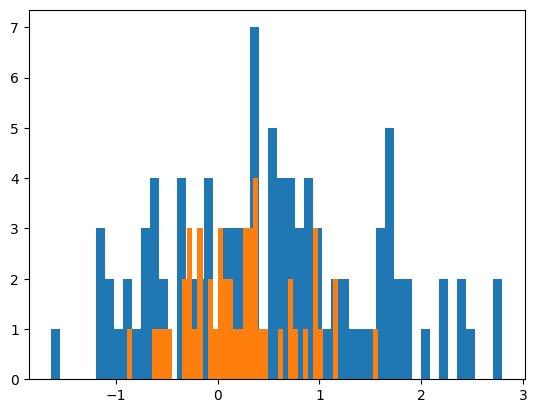

(2.4597239909532593, 0.015059901570983684)

In [ ]:
a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 50)
plt.hist(a, 50)
plt.hist(b, 50)
plt.show()
ttest(a,b)

In [ ]:
a = np.random.normal(0.5, 1, (100,3))
b = np.random.normal(0.5, 1, (50,))
kstest(a,b)

(0.2, 0.0584616647639814)

In [ ]:
a = np.random.normal(0.5, 1, (100,3))
b = np.random.normal(0.15, .5, (50,))
kstest(a,b)

(0.31, 0.0004061333917841914)

In [ ]:
data1 = np.random.normal(0,1,(100, 5, 3))
data2 = np.random.normal(0,2,(100, 5, 3))
kstest(data1, data2, by_axis=1)

([0.21666666666666667,
  0.25333333333333335,
  0.18333333333333332,
  0.20666666666666667,
  0.17666666666666667],
 [1.4007759411179028e-06,
  7.277526651183985e-09,
  8.024952455325493e-05,
  5.0749555303276145e-06,
  0.00016597474985360523])

In [ ]:
a = np.random.normal(0.5, 1, 100)
t = torch.normal(0.5, 1, (100, ))
tscore(a), tscore(t)

(4.659080669220386, tensor(4.8233))

In [ ]:
#|export
def pcc(a, b):
    return pearsonr(a, b)[0]

def scc(a, b):
    return spearmanr(a, b)[0]

a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 100)
pcc(a, b), scc(a, b)

(0.014007857543846727, 0.07308730873087309)

In [ ]:
#|export
def remove_fn(fn, verbose=False):
    "Removes a file (fn) if exists"
    try: 
        os.remove(fn)
        pv(f'{fn} file removed', verbose)
    except OSError: 
        pv(f'{fn} does not exist', verbose)
        pass

In [ ]:
#|export
def npsave(array_fn, array, verbose=True):
    remove_fn(array_fn, verbose)
    pv(f'saving {array_fn}...', verbose)
    np.save(array_fn, array)
    pv(f'...{array_fn} saved', verbose)
    
np_save = npsave

In [ ]:
fn = 'data/remove_fn_test.npy'
a = np.zeros(1)
npsave(fn, a)
del a
np.load(fn, mmap_mode='r+')
remove_fn(fn, True)
remove_fn(fn, True)

data/remove_fn_test.npy does not exist
saving data/remove_fn_test.npy...
...data/remove_fn_test.npy saved
data/remove_fn_test.npy file removed
data/remove_fn_test.npy does not exist


In [ ]:
#|export
def permute_2D(array, axis=None):
    "Permute rows or columns in an array. This can be used, for example, in feature permutation"
    if axis == 0: return array[np.random.randn(*array.shape).argsort(axis=0), np.arange(array.shape[-1])[None, :]] 
    elif axis == 1 or axis == -1: return array[np.arange(len(array))[:,None], np.random.randn(*array.shape).argsort(axis=1)] 
    return array[np.random.randn(*array.shape).argsort(axis=0), np.random.randn(*array.shape).argsort(axis=1)] 

In [ ]:
s = np.arange(100 * 50).reshape(100, 50) 
test_eq(permute_2D(s, axis=0).mean(0), s.mean(0))
test_ne(permute_2D(s, axis=0), s)
test_eq(permute_2D(s, axis=1).mean(1), s.mean(1))
test_ne(permute_2D(s, axis=1), s)
test_ne(permute_2D(s), s)

In [ ]:
#|export
def random_normal():
    "Returns a number between -1 and 1 with a normal distribution"
    while True:
        o = np.random.normal(loc=0., scale=1/3)
        if abs(o) <= 1: break
    return o

def random_half_normal():
    "Returns a number between 0 and 1 with a half-normal distribution"
    while True:
        o = abs(np.random.normal(loc=0., scale=1/3))
        if o <= 1: break
    return o

def random_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between -1 and 1 with a normal distribution"
    return torch.empty(shape, device=device).normal_(mean=0, std=1/3).clamp_(-1, 1)

def random_half_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between 0 and 1 with a half-normal distribution"
    return abs(torch.empty(shape, device=device).normal_(mean=0, std=1/3)).clamp_(0, 1)

In [ ]:
#|export
from matplotlib.backends.backend_agg import FigureCanvasAgg

def default_dpi():
    DPI = plt.gcf().get_dpi()
    plt.close()
    return int(DPI)

def get_plot_fig(size=None, dpi=default_dpi()):
    fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi, frameon=False) if size else plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    config = plt.gcf()
    plt.close('all')
    return config

def fig2buf(fig):
    canvas = FigureCanvasAgg(fig)
    fig.canvas.draw()
    return np.asarray(canvas.buffer_rgba())[..., :3]

In [ ]:
default_dpi()

100

In [ ]:
#|export
def plot_scatter(x, y, deg=1):
    linreg = linregress(x, y)
    plt.scatter(x, y, label=f'R2:{linreg.rvalue:.2f}', color='lime', edgecolor='black', alpha=.5)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, deg))(np.unique(x)), color='r')
    plt.legend(loc='best')
    plt.show()

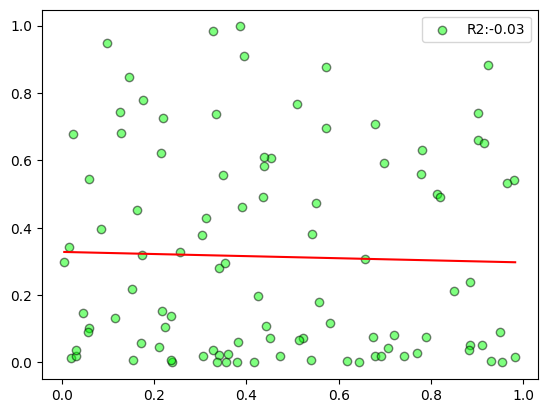

In [ ]:
a = np.random.rand(100)
b = np.random.rand(100)**2
plot_scatter(a, b)

In [ ]:
#|export
def get_idxs(o, aList): return array([o.tolist().index(v) for v in aList])

In [ ]:
a = random_shuffle(np.arange(100, 200))
b = np.random.choice(a, 10, False)
idxs = get_idxs(a, b)
test_eq(a[idxs], b)

In [ ]:
#|export
def apply_cmap(o, cmap):
    o = toarray(o)
    out = plt.get_cmap(cmap)(o)[..., :3]
    out = tensor(out).squeeze(1)
    return out.permute(0, 3, 1, 2)

In [ ]:
a = np.random.rand(16, 1, 40, 50)
s = L(a.shape)
s[1] = 3
test_eq(L(apply_cmap(a, 'viridis').shape), s)

s[0] = 1
a = np.random.rand(1, 40, 50)
test_eq(L(apply_cmap(a, 'viridis').shape), s)

In [ ]:
#|export
def torch_tile(a, n_tile, dim=0):
    if ismin_torch("1.10") and dim == 0:
        if isinstance(n_tile, tuple): 
            return torch.tile(a, n_tile)
        return torch.tile(a, (n_tile,))
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.cat([init_dim * torch.arange(n_tile) + i for i in range(init_dim)]).to(device=a.device)
    return torch.index_select(a, dim, order_index)

In [ ]:
test_eq(torch_tile(torch.arange(2), 3), tensor([0, 1, 0, 1, 0, 1]))

In [ ]:
#|export
def to_tsfresh_df(ts):
    r"""Prepares a time series (Tensor/ np.ndarray) to be used as a tsfresh dataset to allow feature extraction"""
    ts = to3d(ts)
    if isinstance(ts, np.ndarray):
        ids = np.repeat(np.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(0,2,1).reshape(-1, ts.shape[1])
        cols = ['id'] + np.arange(ts.shape[1]).tolist()
        df = pd.DataFrame(np.concatenate([ids, joint_ts], axis=1), columns=cols)
    elif isinstance(ts, torch.Tensor):
        ids = torch_tile(torch.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(1,2).reshape(-1, ts.shape[1])
        cols = ['id']+np.arange(ts.shape[1]).tolist()
        df = pd.DataFrame(torch.cat([ids, joint_ts], dim=1).numpy(), columns=cols)
    df['id'] = df['id'].astype(int)
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
ts = torch.rand(16, 3, 20)
a = to_tsfresh_df(ts)
ts = ts.numpy()
b = to_tsfresh_df(ts)

In [ ]:
#|export
def pcorr(a, b): 
    return pearsonr(a, b)

def scorr(a, b): 
    corr = spearmanr(a, b)
    return corr[0], corr[1]

In [ ]:
#|export
def torch_diff(t, lag=1, pad=True, append=0):
    import torch.nn.functional as F
    diff = t[..., lag:] - t[..., :-lag]
    if pad: 
        return F.pad(diff, (lag, append))
    else: 
        return diff

In [ ]:
t = torch.arange(24).reshape(2,3,4)
test_eq(torch_diff(t, 1)[..., 1:].float().mean(), 1.)
test_eq(torch_diff(t, 2)[..., 2:].float().mean(), 2.)

In [ ]:
#|export
def get_outliers_IQR(o, axis=None, quantile_range=(25.0, 75.0)):
    if isinstance(o, torch.Tensor):
        Q1 = torch.nanquantile(o, quantile_range[0]/100, axis=axis, keepdims=axis is not None)
        Q3 = torch.nanquantile(o, quantile_range[1]/100, axis=axis, keepdims=axis is not None)
    else:
        Q1 = np.nanpercentile(o, quantile_range[0], axis=axis, keepdims=axis is not None)
        Q3 = np.nanpercentile(o, quantile_range[1], axis=axis, keepdims=axis is not None)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

def clip_outliers(o, axis=None):
    min_outliers, max_outliers = get_outliers_IQR(o, axis=axis)
    if isinstance(o, (np.ndarray, pd.core.series.Series)):
        return np.clip(o, min_outliers, max_outliers)
    elif isinstance(o, torch.Tensor):
        return torch.clamp(o, min_outliers, max_outliers)

def get_percentile(o, percentile, axis=None):
    if isinstance(o, torch.Tensor): 
        return torch.nanquantile(o, percentile/100, axis=axis, keepdims=axis is not None)
    else: 
        return np.nanpercentile(o, percentile, axis=axis, keepdims=axis is not None)

def torch_clamp(o, min=None, max=None):
    r"""Clamp torch.Tensor using 1 or multiple dimensions"""
    if min is not None: o = torch.max(o, min)
    if max is not None: o = torch.min(o, max)
    return o

In [ ]:
t = torch.randn(2,3,100)
test_eq(type(get_outliers_IQR(t, -1)[0]), torch.Tensor)
a = t.numpy()
test_eq(type(get_outliers_IQR(a, -1)[0]), np.ndarray)
test_close(get_percentile(t, 25).numpy(), get_percentile(a, 25))

In [ ]:
#|export
def get_robustscale_params(o, sel_vars=None, not_sel_vars=None, by_var=True, percentiles=(25, 75), eps=1e-6):
    "Calculates median and inter-quartile range required to robust scaler inputs"
    assert o.ndim == 3
    if by_var: 
        axis=(0,2)
        keepdims=True
    else:
        axis=None
        keepdims=False
    median = np.nanpercentile(o, 50, axis=axis, keepdims=keepdims)
    Q1 = np.nanpercentile(o, percentiles[0], axis=axis, keepdims=keepdims)
    Q3 = np.nanpercentile(o, percentiles[1], axis=axis, keepdims=keepdims)
    IQR = Q3 - Q1

    if eps is not None: 
        IQR = np.clip(IQR, eps, None)
        
    if sel_vars is not None:
        not_sel_vars = np.asarray([v for v in np.arange(o.shape[1]) if v not in sel_vars])
        
    if not_sel_vars is not None:
        median[:, not_sel_vars] = 0
        IQR[:, not_sel_vars] = 1
        
    return median, IQR


In [ ]:
a = np.random.rand(16, 3, 100)
a[a>.8] = np.nan
median, IQR = get_robustscale_params(a, by_var=True, percentiles=(25, 75))
a_scaled = (a - median) / IQR
test_eq(a.shape, a_scaled.shape)
test_eq(np.isnan(median).sum(),0)
test_eq(np.isnan(IQR).sum(),0)
test_eq(np.isnan(a), np.isnan(a_scaled))

In [ ]:
#|export
def torch_slice_by_dim(t, index, dim=-1, **kwargs):
    if not isinstance(index, torch.Tensor): index = torch.Tensor(index)
    assert t.ndim == index.ndim, "t and index must have the same ndim"
    index = index.long()
    return torch.gather(t, dim, index, **kwargs)

In [ ]:
t = torch.rand(5, 3)
index = torch.randint(0, 3, (5, 1))
# index = [[0, 2], [0, 1], [1, 2], [0, 2], [0, 1]]
torch_slice_by_dim(t, index)

tensor([[0.0703],
        [0.5010],
        [0.3556],
        [0.7908],
        [0.2815]])

In [ ]:
#|export
def torch_nanmean(o, dim=None, keepdim=False):
    """There's currently no torch.nanmean function"""
    mask = torch.isnan(o)
    if mask.any():
        output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
        if output.shape == mask.shape:
            output[mask] = 0
        return output
    else:
        return torch.mean(o, dim=dim, keepdim=keepdim) if dim is not None else torch.mean(o)


def torch_nanstd(o, dim=None, keepdim=False):
    """There's currently no torch.nanstd function"""
    mask = torch.isnan(o)
    if mask.any():
        output = torch.from_numpy(np.asarray(np.nanstd(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
        if output.shape == mask.shape:
            output[mask] = 1
        return output
    else:
        return torch.std(o, dim=dim, keepdim=keepdim) if dim is not None else torch.std(o)

In [ ]:
t = torch.rand(1000)
t[:100] = float('nan')
assert torch_nanmean(t).item() > 0

In [ ]:
#|export
def concat(*ls, dim=0):
    "Concatenate tensors, arrays, lists, or tuples by a dimension"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it, torch.Tensor): return torch.cat(ls, dim=dim)
    elif isinstance(it, np.ndarray): return np.concatenate(ls, axis=dim)
    else:
        res = np.concatenate(ls, axis=dim).tolist()
        return retain_type(res, typ=type(it))

In [ ]:
#|export
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

In [ ]:
#|export
def cls_name(o): return o.__class__.__name__

In [ ]:
test_eq(cls_name(timer), 'Timer')

In [ ]:
#|export
def roll2d(o, roll1: Union[None, list, int] = None, roll2: Union[None, list, int] = None):
    """Rolls a 2D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 2, "roll2D can only be applied to 2d objects"
    axis1, axis2 = np.ogrid[:o.shape[0], :o.shape[1]]
    if roll1 is not None:
        if isinstance(roll1, int): axis1 = axis1 - np.array(roll1).reshape(1,1)
        else: axis1 = np.array(roll1).reshape(o.shape[0],1)
    if roll2 is not None:
        if isinstance(roll2, int):  axis2 = axis2 - np.array(roll2).reshape(1,1)
        else: axis2 = np.array(roll2).reshape(1,o.shape[1])
    return o[axis1, axis2]


def roll3d(o, roll1: Union[None, list, int] = None, roll2: Union[None, list, int] = None, roll3: Union[None, list, int] = None):
    """Rolls a 3D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 3, "roll3D can only be applied to 3d objects"
    axis1, axis2, axis3 = np.ogrid[:o.shape[0], :o.shape[1], :o.shape[2]]
    if roll1 is not None:
        if isinstance(roll1, int): axis1 = axis1 - np.array(roll1).reshape(1,1,1)
        else: axis1 = np.array(roll1).reshape(o.shape[0],1,1)
    if roll2 is not None:
        if isinstance(roll2, int):  axis2 = axis2 - np.array(roll2).reshape(1,1,1)
        else: axis2 = np.array(roll2).reshape(1,o.shape[1],1)
    if roll3 is not None:
        if isinstance(roll3, int):  axis3 = axis3 - np.array(roll3).reshape(1,1,1)
        else: axis3 = np.array(roll3).reshape(1,1,o.shape[2])
    return o[axis1, axis2, axis3]


def random_roll2d(o, axis=(), replace=False):
    """Rolls a 2D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 2, "roll2D can only be applied to 2d objects"
    axis1, axis2 = np.ogrid[:o.shape[0], :o.shape[1]]
    if 0 in axis:
        axis1 = random_choice(np.arange(o.shape[0]), o.shape[0], replace).reshape(-1, 1)
    if 1 in axis:
        axis2 = random_choice(np.arange(o.shape[1]), o.shape[1], replace).reshape(1, -1)
    return o[axis1, axis2]


def random_roll3d(o, axis=(), replace=False):
    """Randomly rolls a 3D object along the indicated axes
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 3, "random_roll3d can only be applied to 3d objects"
    axis1, axis2, axis3 = np.ogrid[:o.shape[0], :o.shape[1], :o.shape[2]]
    if 0 in axis:
        axis1 = random_choice(np.arange(o.shape[0]), o.shape[0], replace).reshape(-1, 1, 1)
    if 1 in axis:
        axis2 = random_choice(np.arange(o.shape[1]), o.shape[1], replace).reshape(1, -1, 1)
    if 2 in axis:
        axis3 = random_choice(np.arange(o.shape[2]), o.shape[2], replace).reshape(1, 1, -1)
    return o[axis1, axis2, axis3]

def rotate_axis0(o, steps=1):
    return o[np.arange(o.shape[0]) - steps]

def rotate_axis1(o, steps=1):
    return o[:, np.arange(o.shape[1]) - steps]

def rotate_axis2(o, steps=1):
    return o[:, :, np.arange(o.shape[2]) - steps]

In [ ]:
a = np.tile(np.arange(10), 3).reshape(3, 10) * np.array([1, 10, 100]).reshape(-1, 1)
a

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90],
       [  0, 100, 200, 300, 400, 500, 600, 700, 800, 900]])

In [ ]:
roll2d(a, roll1=[2, 1, 0])

array([[  0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
       [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9]])

In [ ]:
roll2d(a, roll2=3)

array([[  7,   8,   9,   0,   1,   2,   3,   4,   5,   6],
       [ 70,  80,  90,   0,  10,  20,  30,  40,  50,  60],
       [700, 800, 900,   0, 100, 200, 300, 400, 500, 600]])

In [ ]:
o = torch.arange(24).reshape(2,3,4)
test_eq(rotate_axis0(o)[1], o[0])
test_eq(rotate_axis1(o)[:,1], o[:,0])
test_eq(rotate_axis2(o)[...,1], o[...,0])

In [ ]:
#|export
def chunks_calculator(shape, dtype='float32', n_bytes=1024**3):
    """Function to calculate chunks for a given size of n_bytes (default = 1024**3 == 1GB). 
    It guarantees > 50% of the chunk will be filled"""
    
    X  = np.random.rand(1, *shape[1:]).astype(dtype)
    byts = get_size(X, return_str=False)
    n = n_bytes // byts
    if shape[0] / n <= 1: return False
    remainder = shape[0] % n
    if remainder / n < .5: 
        n_chunks = shape[0] // n
        n += np.ceil(remainder / n_chunks).astype(int)
    return (n, -1, -1)

In [ ]:
shape = (1_000, 10, 1000)
dtype = 'float32'
test_eq(chunks_calculator(shape, dtype), False)

shape = (54684, 10, 1000)
dtype = 'float32'
test_eq(chunks_calculator(shape, dtype), (27342, -1, -1))

In [ ]:
#|export
def is_memory_shared(a, b):
    "Check if 2 array-like objects share memory"
    assert is_array(a) and is_array(b)
    return np.shares_memory(a, b)

In [ ]:
a = np.random.rand(2,3,4)
t1 = torch.from_numpy(a)
test_eq(is_memory_shared(a, t1), True)
a = np.random.rand(2,3,4)
t2 = torch.as_tensor(a)
test_eq(is_memory_shared(a, t2), True)
a = np.random.rand(2,3,4)
t3 = torch.tensor(a)
test_eq(is_memory_shared(a, t3), False)

In [ ]:
#|export
def assign_in_chunks(a, b, chunksize='auto', inplace=True, verbose=True):
    """Assigns values in b to an array-like object a using chunks to avoid memory overload.
    The resulting a retains it's dtype and share it's memory.
    a: array-like object
    b: may be an integer, float, str, 'rand' (for random data), or another array like object.
    chunksize: is the size of chunks. If 'auto' chunks will have around 1GB each.
    """

    if b != 'rand' and not isinstance(b, (Iterable, Generator)):
        a[:] = b
    else:
        shape = a.shape
        dtype = a.dtype
        if chunksize == "auto":
            chunksize = chunks_calculator(shape, dtype)
            chunksize = shape[0] if not chunksize else  chunksize[0]
            if verbose: 
                print(f'auto chunksize: {chunksize}')
        for i in progress_bar(range((shape[0] - 1) // chunksize + 1), display=verbose, leave=False):
            start, end = i * chunksize, min(shape[0], (i + 1) * chunksize)
            if start >= shape[0]: break
            if b == 'rand':
                a[start:end] = np.random.rand(end - start, *shape[1:])
            else:
                if is_dask(b):
                    a[start:end] = b[start:end].compute()
                else:
                    a[start:end] = b[start:end]
    if not inplace: return a

In [ ]:
a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = np.random.rand(10,3,4).astype('float64')
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_close(a, b)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 1
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a, np.ones_like(a).astype(a.dtype))
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 0.5
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 'rand'
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

In [ ]:
a = np.random.rand(10,3,4).astype('float32')
b = np.random.rand(10,3,4).astype('float64')
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_close(c, b)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 1
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a, np.ones_like(a).astype(a.dtype))
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 0.5
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 'rand'
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

In [ ]:
#|export
def create_array(shape, fname=None, path='./data', on_disk=True, dtype='float32', mode='r+', fill_value='rand', chunksize='auto', verbose=True, **kwargs):
    """
    mode:
        ‘r’:  Open existing file for reading only.
        ‘r+’: Open existing file for reading and writing.
        ‘w+’: Create or overwrite existing file for reading and writing.
        ‘c’:  Copy-on-write: assignments affect data in memory, but changes are not saved to disk. The file on disk is read-only.
    fill_value: 'rand' (for random numbers), int or float
    chunksize = 'auto' to calculate chunks of 1GB, or any integer (for a given number of samples)
    """
    if on_disk:
        assert fname is not None, 'you must provide a fname (filename)'
        path = Path(path)
        if not fname.endswith('npy'): fname = f'{fname}.npy'
        filename = path/fname
        filename.parent.mkdir(parents=True, exist_ok=True)
        # Save a small empty array
        _temp_fn = path/'temp_X.npy'
        np.save(_temp_fn, np.empty(0))
        # Create  & save file
        arr = np.memmap(_temp_fn, dtype=dtype, mode='w+', shape=shape, **kwargs)
        np.save(filename, arr)
        del arr
        os.remove(_temp_fn)
        # Open file in selected mode
        arr = np.load(filename, mmap_mode=mode)
    else:
        arr = np.empty(shape, dtype=dtype, **kwargs)
    if fill_value != 0:
        assign_in_chunks(arr, fill_value, chunksize=chunksize, inplace=True, verbose=verbose)
    return arr

create_empty_array = partial(create_array, fill_value=0)

In [ ]:
fname = 'X_on_disk'
shape = (100, 10, 10)
X = create_array(shape, fname, on_disk=True, mode='r+')
test_ne(abs(X).sum(), 0)
os.remove(X.filename)
del X

In [ ]:
fname = 'X_on_disk'
shape = (100, 10, 10)
X = create_empty_array(shape, fname, on_disk=True, mode='r+')
test_eq(abs(X).sum(), 0)

chunksize = 10
pbar = progress_bar(range(math.ceil(len(X) / chunksize)), leave=False)
start = 0
for i in pbar: 
    end = min(start + chunksize, len(X))
    partial_data = np.random.rand(end - start, X.shape[1] , X.shape[2])
    X[start:end] = partial_data
    start = end
    del partial_data
    gc.collect()
filename = X.filename
del X
X = np.load(filename, mmap_mode='r+')
test_eq((X == 0).sum(), 0)
test_eq(X.shape, shape)
os.remove(X.filename)
del X

In [ ]:
#|export
import gzip

def np_save_compressed(arr, fname=None, path='./data', verbose=False, **kwargs):
    assert fname is not None, 'you must provide a fname (filename)'
    if fname.endswith('npy'): fname = f'{fname}.gz'
    elif not fname.endswith('npy.gz'): fname = f'{fname}.npy.gz'
    filename = Path(path)/fname
    filename.parent.mkdir(parents=True, exist_ok=True)
    f = gzip.GzipFile(filename, 'w', **kwargs)
    np.save(file=f, arr=arr)
    f.close()
    pv(f'array saved to {filename}', verbose)
    
def np_load_compressed(fname=None, path='./data', **kwargs):
    assert fname is not None, 'you must provide a fname (filename)'
    if fname.endswith('npy'): fname = f'{fname}.gz'
    elif not fname.endswith('npy.gz'): fname = f'{fname}.npy.gz'
    filename = Path(path)/fname
    f = gzip.GzipFile(filename, 'r', **kwargs)
    arr = np.load(f)
    f.close()
    return arr

In [ ]:
X1 = np.random.rand(10)
np_save_compressed(X1, 'X_comp', path='./data')
X2 = np_load_compressed('X_comp')
test_eq(X1, X2)

In [ ]:
#|export
def np2memmap(arr, fname=None, path='./data', dtype='float32', mode='c', **kwargs):
    """ Function that turns an ndarray into a memmap ndarray
    mode:
        ‘r’:  Open existing file for reading only.
        ‘r+’: Open existing file for reading and writing.
        ‘w+’: Create or overwrite existing file for reading and writing.
        ‘c’:  Copy-on-write: assignments affect data in memory, but changes are not saved to disk. The file on disk is read-only.
    """
    assert fname is not None, 'you must provide a fname (filename)'
    if not fname.endswith('npy'): fname = f'{fname}.npy'
    filename = Path(path)/fname
    filename.parent.mkdir(parents=True, exist_ok=True)
    # Save file
    np.save(filename, arr)
    # Open file in selected mode
    arr = np.load(filename, mmap_mode=mode)
    return arr

In [ ]:
X1 = np.random.rand(10)
X2 = np2memmap(X1, 'X1_test')
test_eq(X1, X2)
test_ne(type(X1), type(X2))

In [ ]:
#|export 
def torch_mean_groupby(o, idxs):
    """Computes torch mean along axis 0 grouped by the idxs. 
    Need to ensure that idxs have the same order as o"""
    if is_listy(idxs[0]): idxs = flatten_list(idxs)
    flattened_idxs = torch.tensor(idxs)
    idxs, vals = torch.unique(flattened_idxs, return_counts=True)
    vs = torch.split_with_sizes(o, tuple(vals))
    return torch.cat([v.mean(0).unsqueeze(0) for k,v in zip(idxs, vs)])

In [ ]:
o = torch.arange(6*2*3).reshape(6, 2, 3).float()
idxs = np.array([[0,1,2,3], [2,3]], dtype=object)
output = torch_mean_groupby(o, idxs)
test_eq(o[:2], output[:2])
test_eq(o[2:4].mean(0), output[2])
test_eq(o[4:6].mean(0), output[3])

In [ ]:
#|export
def torch_flip(t, dims=-1):
    if dims == -1: return t[..., np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 0: return t[np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 1: return t[:, np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 2: return t[:, :, np.arange(t.shape[dims])[::-1].copy()]

In [ ]:
t = torch.randn(2, 3, 4)
test_eq(torch.flip(t, (2,)), torch_flip(t, dims=-1))

In [ ]:
#|export 
def torch_nan_to_num(o, num=0, inplace=False):
    if ismin_torch("1.8") and not inplace: 
        return torch.nan_to_num(o, num)
    mask = torch.isnan(o)
    return torch_masked_to_num(o, mask, num=num, inplace=inplace)

def torch_masked_to_num(o, mask, num=0, inplace=False):
    if inplace: 
        o[:] = o.masked_fill(mask, num)
    else: 
        return o.masked_fill(mask, num)

In [ ]:
x = torch.rand(2, 4, 6)
x[:, :3][x[:, :3] < .5] = np.nan
nan_values = torch.isnan(x).sum()
y = torch_nan_to_num(x[:, :3], inplace=False)
test_eq(torch.isnan(y).sum(), 0)
test_eq(torch.isnan(x).sum(), nan_values)
torch_nan_to_num(x[:, :3], inplace=True)
test_eq(torch.isnan(x).sum(), 0)

In [ ]:
x = torch.rand(2, 4, 6)
mask = x[:, :3] > .5
x[:, :3] = torch_masked_to_num(x[:, :3], mask, num=0, inplace=False)
test_eq(x[:, :3][mask].sum(), 0)

In [ ]:
x = torch.rand(2, 4, 6)
mask = x[:, :3] > .5
torch_masked_to_num(x[:, :3], mask, num=0, inplace=True)
test_eq(x[:, :3][mask].sum(), 0)

In [ ]:
#|export
def mpl_trend(x, y, deg=1): 
    return np.poly1d(np.polyfit(x, y, deg))(x)

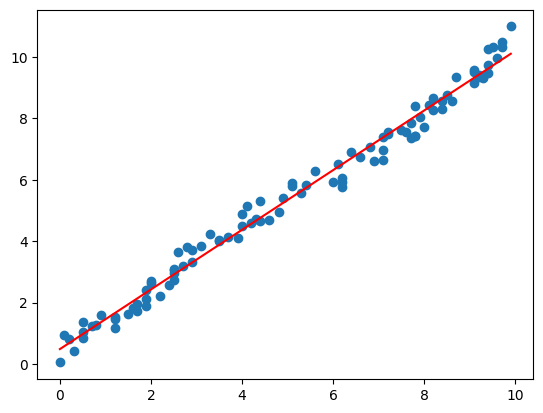

In [ ]:
x = np.sort(np.random.randint(0, 100, 100)/10)
y = np.random.rand(100) + np.linspace(0, 10, 100)
trend = mpl_trend(x, y)
plt.scatter(x, y)
plt.plot(x, trend, 'r')
plt.show()

In [ ]:
#|export
def int2digits(o, n_digits=None, normalize=True):
    if n_digits is not None:
        iterable = '0' * (n_digits - len(str(abs(o)))) + str(abs(o))
    else:
        iterable = str(abs(o))
    sign = np.sign(o)
    digits = np.array([sign * int(d) for d in iterable])
    if normalize:
        digits = digits / 10
    return digits


def array2digits(o, n_digits=None, normalize=True):
    output = np.array(list(map(partial(int2digits, n_digits=n_digits), o)))
    if normalize:
        output = output / 10
    return output

In [ ]:
o = -9645
test_eq(int2digits(o, 6), np.array([ 0,  0, -.9, -.6, -.4, -.5]))

a = np.random.randint(-1000, 1000, 10)
test_eq(array2digits(a,5).shape, (10,5))

In [ ]:
#|export
def sincos_encoding(seq_len, device=None, to_np=False):
    if to_np:
        sin = np.sin(np.arange(seq_len) / seq_len * 2 * np.pi)
        cos = np.cos(np.arange(seq_len) / seq_len * 2 * np.pi)
    else:
        if device is None: device = default_device()
        sin = torch.sin(torch.arange(seq_len, device=device) / seq_len * 2 * np.pi)
        cos = torch.cos(torch.arange(seq_len, device=device) / seq_len * 2 * np.pi)
    return sin, cos

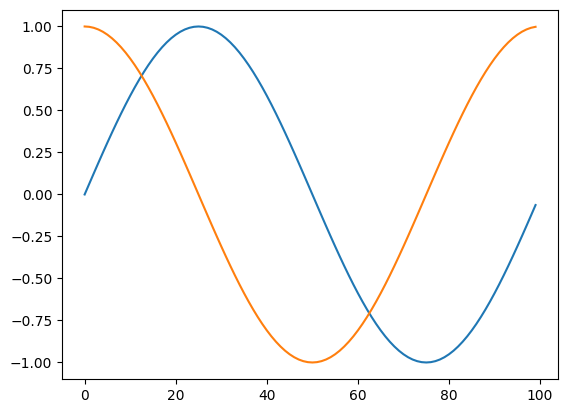

In [ ]:
sin, cos = sincos_encoding(100)
plt.plot(sin.cpu().numpy())
plt.plot(cos.cpu().numpy())
plt.show()

In [ ]:
#|export
def linear_encoding(seq_len, device=None, to_np=False, lin_range=(-1,1)):
    if to_np:
        enc =  np.linspace(lin_range[0], lin_range[1], seq_len)
    else:
        if device is None: device = default_device()
        enc = torch.linspace(lin_range[0], lin_range[1], seq_len, device=device)
    return enc

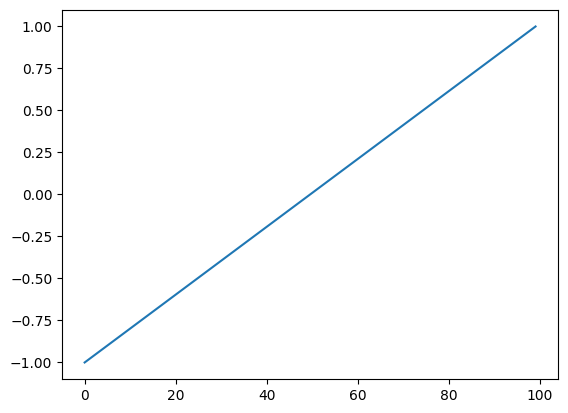

In [ ]:
lin = linear_encoding(100)
plt.plot(lin.cpu().numpy())
plt.show()

In [ ]:
#|export
def encode_positions(pos_arr, min_val=None, max_val=None, linear=False, lin_range=(-1,1)):
    """ Encodes an array with positions using a linear or sincos methods
    """
    
    if min_val is None:
        min_val = np.nanmin(pos_arr)
    if max_val is None:
        max_val = np.nanmax(pos_arr)
        
    if linear: 
        return (((pos_arr - min_val)/(max_val - min_val)) * (lin_range[1] - lin_range[0]) + lin_range[0])
    else:
        sin = np.sin((pos_arr - min_val)/(max_val - min_val) * 2 * np.pi)
        cos = np.cos((pos_arr - min_val)/(max_val - min_val) * 2 * np.pi)
        return sin, cos

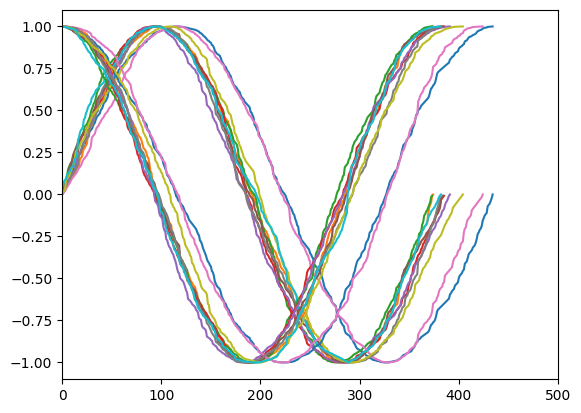

In [ ]:
n_samples = 10
length = 500
_a = []
for i in range(n_samples):
    a = np.arange(-4000, 4000, 10)
    mask = np.random.rand(len(a)) > .5
    a = a[mask]
    a = np.concatenate([a, np.array([np.nan] * (length - len(a)))])
    _a.append(a.reshape(-1,1))
a = np.concatenate(_a, -1).transpose(1,0)
sin, cos = encode_positions(a, linear=False)
test_eq(a.shape, (n_samples, length))
test_eq(sin.shape, (n_samples, length))
test_eq(cos.shape, (n_samples, length))
plt.plot(sin.T)
plt.plot(cos.T)
plt.xlim(0, 500)
plt.show()

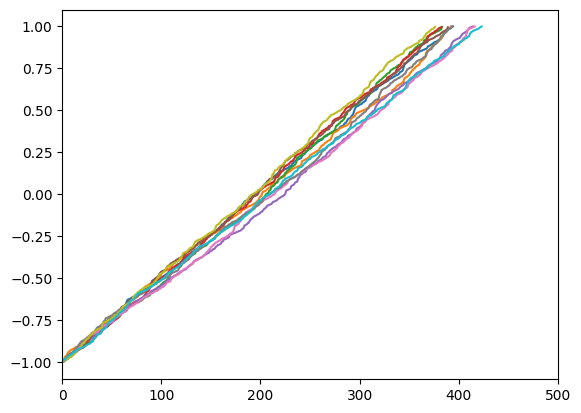

In [ ]:
n_samples = 10
length = 500
_a = []
for i in range(n_samples):
    a = np.arange(-4000, 4000, 10)
    mask = np.random.rand(len(a)) > .5
    a = a[mask]
    a = np.concatenate([a, np.array([np.nan] * (length - len(a)))])
    _a.append(a.reshape(-1,1))
a = np.concatenate(_a, -1).transpose(1,0)
lin = encode_positions(a, linear=True)
test_eq(a.shape, (n_samples, length))
test_eq(lin.shape, (n_samples, length))
plt.plot(lin.T)
plt.xlim(0, 500)
plt.show()

In [ ]:
#|export
def sort_generator(generator, bs):
    g = list(generator)
    for i in range(len(g)//bs + 1): g[bs*i:bs*(i+1)] = np.sort(g[bs*i:bs*(i+1)])
    return (i for i in g)

In [ ]:
generator = (i for i in np.random.permutation(np.arange(1000000)).tolist())
l = list(sort_generator(generator, 512))
test_eq(l[:512], sorted(l[:512]))

In [ ]:
#|export
def get_subset_dict(d, keys):
    return dict((k,d[k]) for k in listify(keys) if k in d)

In [ ]:
keys = string.ascii_lowercase
values = np.arange(len(keys))
d = {k:v for k,v in zip(keys,values)}
test_eq(get_subset_dict(d, ['a', 'k', 'j', 'e']), {'a': 0, 'k': 10, 'j': 9, 'e': 4})

In [ ]:
#|export
def create_dir(directory, verbose=True): 
    if not is_listy(directory): directory = [directory]
    for d in directory:
        d = Path(d)
        if d.exists():
            if verbose: print(f"{d} directory already exists.")
        else: 
            d.mkdir(parents=True, exist_ok=True)
            assert d.exists(),  f"a problem has occurred while creating {d}"
            if verbose: print(f"{d} directory created.")


def remove_dir(directory, verbose=True):
    import shutil
    if not is_listy(directory): directory = [directory]
    for d in directory:
        d = Path(d)
        if d.is_file(): d = d.parent
        if not d.exists():
            if verbose: print(f"{d} directory doesn't exist.")
        else:
            shutil.rmtree(d)
            assert not d.exists(), f"a problem has occurred while deleting {d}"
            if verbose: print(f"{d} directory removed.")

In [ ]:
path = "wandb3/wandb2/wandb"
create_dir(path)
assert Path(path).exists()

paths = ["wandb3/wandb2/wandb", "wandb3/wandb2", "wandb"]
remove_dir(paths)
for p in paths: 
    assert not Path(p).exists()

path = "wandb3"
assert Path(path).exists()
remove_dir(path)
assert not Path(path).exists()

wandb3/wandb2/wandb directory created.
wandb3/wandb2/wandb directory removed.
wandb3/wandb2 directory removed.
wandb directory doesn't exist.
wandb3 directory removed.


In [ ]:
create_dir('./test')

test directory created.


In [ ]:
%%file ./test/mod_dev.py
a = 5
def fn(b): return a + b

Writing ./test/mod_dev.py


In [ ]:
fname = "./test/mod_dev.py"
while True: 
    if fname[0] in "/ .": fname = fname.split(fname[0], 1)[1]
    else: break
if '/' in fname and fname.rsplit('/', 1)[0] not in sys.path: sys.path.append(fname.rsplit('/', 1)[0])
mod = import_file_as_module(fname)
test_eq(mod.fn(3), 8)
sys.path = sys.path[:-1]
remove_dir('./test/')

test directory removed.


In [ ]:
#|export
class named_partial(object):
    """Create a partial function with a __name__"""
    
    def __init__(self, name, func, *args, **kwargs):
        self._func = partial(func, *args, **kwargs)
        self.__name__ = name
    def __call__(self, *args, **kwargs):
        return self._func(*args, **kwargs)
    def __repr__(self):
        return self.__name__

In [ ]:
def add_1(x, add=1): return x+add
test_eq(add_1(1), 2)
add_2 = partial(add_1, add=2)
test_eq(add_2(2), 4)
test_ne(str(add_2), "add_2")
add_2 = named_partial('add_2', add_1, add=2)
test_eq(add_2(2), 4)
test_eq(str(add_2), "add_2")

class _A():
    def __init__(self, add=1): self.add = add
    def __call__(self, x): return x + self.add
    
test_eq(_A()(1), 2)
_A2 = partial(_A, add=2)
test_eq(_A2()(1), 3)
test_ne(str(_A2), '_A2')
_A2 = named_partial('_A2', _A, add=2)
test_eq(_A2()(1), 3)
test_eq(str(_A2), '_A2')

In [ ]:
#|export
def attrdict2dict(
    d: dict,  # a dict
):
    "Converts a (nested) AttrDict dict to a dict."
    d = dict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = attrdict2dict(d[k])
        elif is_listy(v):
            d[k] = list(v)  # convert L to list
    return d


def dict2attrdict(
    d: dict,  # a dict
):
    "Converts a (nested) dict to an AttrDict."
    d = dict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dict2attrdict(d[k])
        elif is_listy(v):
            d[k] = list(v)  # convert L to list
    return AttrDict(d)

In [ ]:
# Test attrdict2dict
d = AttrDict({'a': 1, 'b': AttrDict({'c': 2, 'd': 3})})
test_eq(attrdict2dict(d), {'a': 1, 'b': {'c': 2, 'd': 3}})
# Test dict2attrdict
d = {'a': 1, 'b': {'c': 2, 'd': 3}}
test_eq(dict2attrdict(d), AttrDict({'a': 1, 'b': AttrDict({'c': 2, 'd': 3})}))

In [ ]:
#|export
def dict2yaml(
    d, # a dict
    file_path, # a path to a yaml file
    sort_keys=False, # if True, sort the keys
):
    "Converts a dict to a yaml file."
    file_path = Path(file_path)
    if not file_path.suffix == '.yaml':
        file_path = file_path.with_suffix(".yaml")
    file_path.parent.mkdir(parents=True, exist_ok=True)
    with open(file_path, "w") as outfile:
        yaml.dump(d, outfile, default_flow_style=False, sort_keys=sort_keys)


def yaml2dict(
    file_path, # a path to a yaml file
    attrdict=True, # if True, convert output to AttrDict
):
    "Converts a yaml file to a dict (optionally AttrDict)."
    file_path = Path(file_path)
    if not file_path.suffix == '.yaml':
        file_path = file_path.with_suffix(".yaml")
    with open(file_path, "r") as infile:
        d = yaml.load(infile, Loader=yaml.FullLoader)
    if not d:  # if file is empty
        return {}
    return dict2attrdict(d) if attrdict else d


def get_config(file_path):
    "Gets a config from a yaml file."
    file_path = Path(file_path)
    if not file_path.suffix == ".yaml":
        file_path = file_path.with_suffix(".yaml")
    cfg = yaml2dict(file_path)
    config = cfg.get("config") or cfg
    config = dict2attrdict(config)
    return config

In [ ]:
%%file sweep_config.yaml

program: wandb_scripts/train_script.py          # (required) Path to training script.
method: bayes                                   # (required) Specify the search strategy: grid, random or bayes
parameters:                                     # (required) Specify parameters bounds to search.
   bs:
      values: [32, 64, 128]
   depth:
      values: [3, 6, 9, 12]
   fc_dropout:
      distribution: uniform
      min: 0.
      max: 0.5
   lr_max:
      values: [0.001, 0.003, 0.01, 0.03, 0.1]
   n_epoch:
      values: [10, 15, 20]
   nb_filters:
      values: [32, 64, 128]
name: LSST_sweep_01
metric: 
   name: accuracy                              # This must match one of the metrics in the training script
   goal: maximize
early_terminate: 
   type: hyperband
   min_iter: 3
project: LSST_wandb_hpo

Writing sweep_config.yaml


In [ ]:
fname = "sweep_config.yaml"
sweep_config = yaml2dict(fname)
print(sweep_config)
test_eq(sweep_config.method, 'bayes')
test_eq(sweep_config['metric'], {'name': 'accuracy', 'goal': 'maximize'})
os.remove(fname)

{'program': 'wandb_scripts/train_script.py', 'method': 'bayes', 'parameters': {'bs': {'values': [32, 64, 128]}, 'depth': {'values': [3, 6, 9, 12]}, 'fc_dropout': {'distribution': 'uniform', 'min': 0.0, 'max': 0.5}, 'lr_max': {'values': [0.001, 0.003, 0.01, 0.03, 0.1]}, 'n_epoch': {'values': [10, 15, 20]}, 'nb_filters': {'values': [32, 64, 128]}}, 'name': 'LSST_sweep_01', 'metric': {'name': 'accuracy', 'goal': 'maximize'}, 'early_terminate': {'type': 'hyperband', 'min_iter': 3}, 'project': 'LSST_wandb_hpo'}


In [ ]:
#|export
def str2list(o):
    if o is None: return []
    elif o is not None and not isinstance(o, (list, L)):
        if isinstance(o, pd.core.indexes.base.Index): o = o.tolist()
        else: o = [o]
    return o

def str2index(o):
    if o is None: return o
    o = str2list(o)
    if len(o) == 1: return o[0]
    return o

def get_cont_cols(df):
    return df._get_numeric_data().columns.tolist()

def get_cat_cols(df):
    cols = df.columns.tolist()
    cont_cols = df._get_numeric_data().columns.tolist()
    return [col for col in cols if col not in cont_cols]

In [ ]:
#|export
alphabet = L(list(string.ascii_lowercase))
ALPHABET = L(list(string.ascii_uppercase))

In [ ]:
#|export
def get_mapping(arr, dim=1, return_counts=False):
    maps = [L(np.unique(np.take(arr, i, dim)).tolist()) for i in range(arr.shape[dim])]
    if return_counts:
        counts = [len(m) for m in maps]
        return maps, counts
    return maps

def map_array(arr, dim=1):
    out = stack([np.unique(np.take(arr, i, dim), return_inverse=True)[1] for i in range(arr.shape[dim])])
    if dim == 1: out = out.T
    return out

In [ ]:
a = np.asarray(alphabet[np.random.randint(0,15,30)]).reshape(10,3)
b = np.asarray(ALPHABET[np.random.randint(6,10,30)]).reshape(10,3)
x = concat(a,b,dim=1)
maps, counts = get_mapping(x, dim=1, return_counts=True)
x, maps, counts

(array([['o', 'd', 'k', 'H', 'G', 'J'],
        ['i', 'a', 'i', 'H', 'J', 'G'],
        ['j', 'k', 'm', 'J', 'G', 'H'],
        ['b', 'h', 'm', 'J', 'G', 'J'],
        ['d', 'k', 'a', 'G', 'I', 'J'],
        ['e', 'e', 'b', 'J', 'I', 'I'],
        ['e', 'd', 'o', 'G', 'J', 'I'],
        ['m', 'f', 'c', 'J', 'I', 'J'],
        ['i', 'l', 'l', 'H', 'J', 'G'],
        ['h', 'a', 'm', 'I', 'H', 'G']], dtype='<U1'),
 [(#8) ['b','d','e','h','i','j','m','o'],
  (#7) ['a','d','e','f','h','k','l'],
  (#8) ['a','b','c','i','k','l','m','o'],
  (#4) ['G','H','I','J'],
  (#4) ['G','H','I','J'],
  (#4) ['G','H','I','J']],
 [8, 7, 8, 4, 4, 4])

In [ ]:
x = np.asarray(alphabet[np.random.randint(0,15,30)]).reshape(10,3)
x, map_array(x), map_array(x, 1)

(array([['g', 'b', 'c'],
        ['o', 'j', 'f'],
        ['k', 'k', 'n'],
        ['g', 'a', 'o'],
        ['f', 'a', 'd'],
        ['g', 'b', 'c'],
        ['b', 'j', 'c'],
        ['d', 'l', 'g'],
        ['a', 'k', 'h'],
        ['l', 'j', 'n']], dtype='<U1'),
 array([[4, 1, 0],
        [7, 2, 2],
        [5, 3, 5],
        [4, 0, 6],
        [3, 0, 1],
        [4, 1, 0],
        [1, 2, 0],
        [2, 4, 3],
        [0, 3, 4],
        [6, 2, 5]]),
 array([[4, 1, 0],
        [7, 2, 2],
        [5, 3, 5],
        [4, 0, 6],
        [3, 0, 1],
        [4, 1, 0],
        [1, 2, 0],
        [2, 4, 3],
        [0, 3, 4],
        [6, 2, 5]]))

In [ ]:
#|export
def log_tfm(o, inplace=False):
    "Log transforms an array-like object with positive and/or negative values"
    if isinstance(o, torch.Tensor):
        pos_o = torch.log1p(o[o > 0])
        neg_o = -torch.log1p(torch.abs(o[o < 0]))
    else: 
        pos_o = np.log1p(o[o > 0])
        neg_o = -np.log1p(np.abs(o[o < 0]))
    if inplace:
        o[o > 0] = pos_o
        o[o < 0] = neg_o
        return o
    else:
        if hasattr(o, "clone"): output = o.clone()
        elif hasattr(o, "copy"): output = o.copy()
        output[output > 0] = pos_o
        output[output < 0] = neg_o
        return output

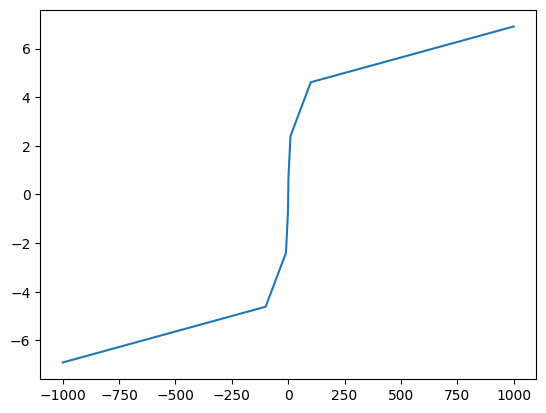

In [ ]:
arr = np.asarray([-1000, -100, -10, -1, 0, 1, 10, 100, 1000]).astype(float)
plt.plot(arr, log_tfm(arr, False))
plt.show()

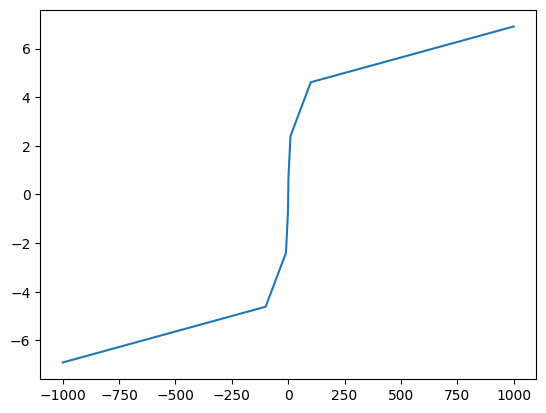

In [ ]:
t = tensor([-1000, -100, -10, -1, 0, 1, 10, 100, 1000]).float()
plt.plot(t, log_tfm(t, False))
plt.show()

In [ ]:
#|export
def to_sincos_time(arr, max_value):
    sin = np.sin(arr / max_value * 2 * np.pi)
    cos = np.cos(arr / max_value * 2 * np.pi)
    return sin, cos

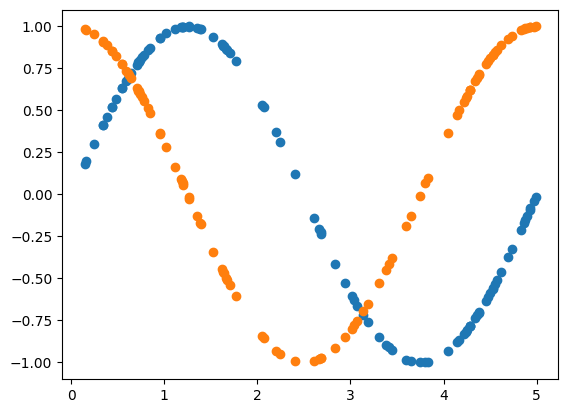

In [ ]:
arr = np.sort(np.random.rand(100) * 5)
arr_sin, arr_cos = to_sincos_time(arr, 5)
plt.scatter(arr, arr_sin)
plt.scatter(arr, arr_cos)
plt.show()

In [ ]:
#|export
def plot_feature_dist(X, percentiles=[0,0.1,0.5,1,5,10,25,50,75,90,95,99,99.5,99.9,100]):
    for i in range(X.shape[1]):
        ys = []
        for p in percentiles:
            ys.append(np.percentile(X[:, i].flatten(), p))
        plt.plot(percentiles, ys)
        plt.xticks(percentiles, rotation='vertical')
        plt.grid(color='gainsboro', linewidth=.5)
        plt.title(f"var_{i}")
        plt.show()

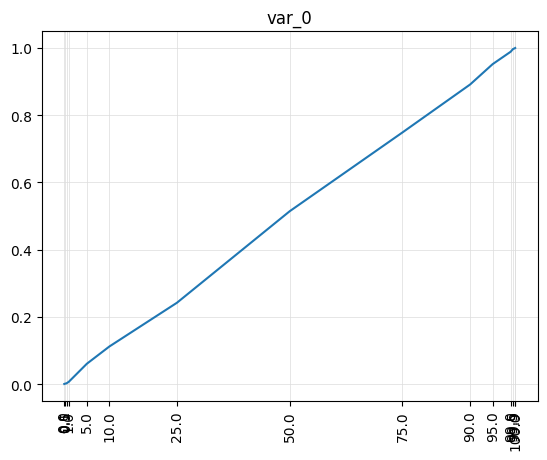

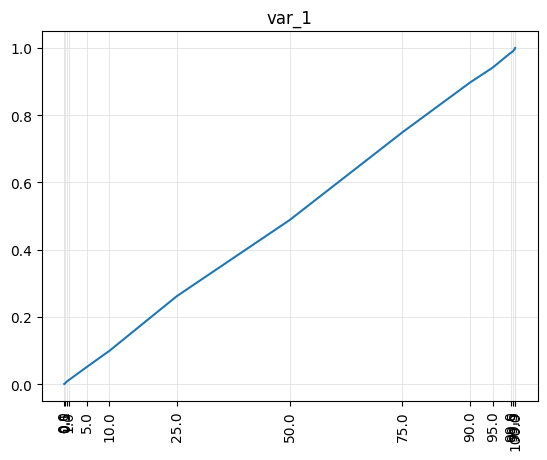

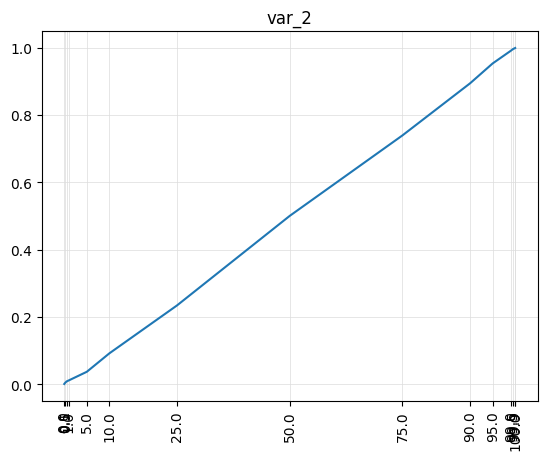

In [ ]:
arr = np.random.rand(10, 3, 100)
plot_feature_dist(arr, percentiles=[0,0.1,0.5,1,5,10,25,50,75,90,95,99,99.5,99.9,100])

In [ ]:
#|export
def rolling_moving_average(o, window=2):
    if isinstance(o, torch.Tensor):
        cunsum = torch.cumsum(o, axis=-1) # nancumsum not available (can't be used with missing data!)
        lag_cunsum = torch.cat([torch.zeros((o.shape[0], o.shape[1], window), device=o.device), torch.cumsum(o[..., :-window], axis=-1)], -1)
        count = torch.clip(torch.ones_like(o).cumsum(-1), max=window)
        return (cunsum - lag_cunsum) / count
    else:
        cunsum = np.nancumsum(o, axis=-1)
        lag_cunsum = np.concatenate([np.zeros((o.shape[0], o.shape[1], window)), np.nancumsum(o[..., :-window], axis=-1)], -1)
        count = np.minimum(np.ones_like(o).cumsum(-1), window)
        return (cunsum - lag_cunsum) / count

In [ ]:
a = np.arange(60).reshape(2,3,10).astype(float)
t = torch.arange(60).reshape(2,3,10).float()
test_close(rolling_moving_average(a, window=3), rolling_moving_average(t, window=3).numpy())
print(t)
print(rolling_moving_average(t, window=3))

tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.]],

        [[30., 31., 32., 33., 34., 35., 36., 37., 38., 39.],
         [40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
         [50., 51., 52., 53., 54., 55., 56., 57., 58., 59.]]])
tensor([[[ 0.0000,  0.5000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,
           6.0000,  7.0000,  8.0000],
         [10.0000, 10.5000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
          16.0000, 17.0000, 18.0000],
         [20.0000, 20.5000, 21.0000, 22.0000, 23.0000, 24.0000, 25.0000,
          26.0000, 27.0000, 28.0000]],

        [[30.0000, 30.5000, 31.0000, 32.0000, 33.0000, 34.0000, 35.0000,
          36.0000, 37.0000, 38.0000],
         [40.0000, 40.5000, 41.0000, 42.0000, 43.0000, 44.0000, 45.0000,
          46.0000, 47.0000, 48.0000],
         [50.0000, 50.5000, 51.0000, 52.0000, 53.0000, 54.0000, 55.0000,


In [ ]:
#|export
def ffill_sequence(o):
    """Forward fills an array-like object alongside sequence dimension"""
    if isinstance(o, torch.Tensor):
        mask = torch.isnan(o)
        idx = torch.where(~mask, torch.arange(mask.shape[-1], device=o.device), 0)
        idx = torch.cummax(idx, dim=-1).values
        return o[torch.arange(o.shape[0], device=o.device)[:,None,None], torch.arange(o.shape[1], device=o.device)[None,:,None], idx]
    else:
        mask = np.isnan(o)
        idx = np.where(~mask, np.arange(mask.shape[-1]), 0)
        idx = np.maximum.accumulate(idx, axis=-1)
        return o[np.arange(o.shape[0])[:,None,None], np.arange(o.shape[1])[None,:,None], idx]

def bfill_sequence(o):
    """Backward fills an array-like object alongside sequence dimension"""
    if isinstance(o, torch.Tensor):
        o = torch.flip(o, (-1,))
        o = ffill_sequence(o)
        return torch.flip(o, (-1,))
    else:
        o = o[..., ::-1]
        o = ffill_sequence(o)
        return o[..., ::-1]

def fbfill_sequence(o):
    """Forward and backward fills an array-like object alongside sequence dimension"""
    o = ffill_sequence(o)
    o = bfill_sequence(o)
    return o

In [ ]:
a = np.arange(80).reshape(2, 4, 10).astype(float)
mask = np.random.rand(*a.shape)
a[mask > .8] = np.nan
t = torch.from_numpy(a)
t

tensor([[[ 0.,  1.,  2.,  3., nan,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., nan],
         [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
         [30., nan, nan, nan, 34., 35., 36., 37., 38., 39.]],

        [[40., nan, 42., 43., 44., nan, 46., 47., 48., 49.],
         [50., 51., 52., 53., 54., 55., nan, 57., 58., 59.],
         [60., 61., nan, 63., 64., 65., nan, 67., 68., 69.],
         [70., 71., 72., nan, 74., 75., 76., 77., 78., nan]]],
       dtype=torch.float64)

In [ ]:
# forward fill
filled_a = ffill_sequence(a)
print(filled_a)
m = np.isnan(filled_a)
test_eq(filled_a[~m], ffill_sequence(t).numpy()[~m])

[[[ 0.  1.  2.  3.  3.  5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14. 15. 16. 17. 18. 18.]
  [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 30. 30. 30. 34. 35. 36. 37. 38. 39.]]

 [[40. 40. 42. 43. 44. 44. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54. 55. 55. 57. 58. 59.]
  [60. 61. 61. 63. 64. 65. 65. 67. 68. 69.]
  [70. 71. 72. 72. 74. 75. 76. 77. 78. 78.]]]


In [ ]:
# backward fill
filled_a = bfill_sequence(a)
print(filled_a)
m = np.isnan(filled_a)
test_eq(filled_a[~m], bfill_sequence(t).numpy()[~m])

[[[ 0.  1.  2.  3.  5.  5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
  [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 34. 34. 34. 34. 35. 36. 37. 38. 39.]]

 [[40. 42. 42. 43. 44. 46. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54. 55. 57. 57. 58. 59.]
  [60. 61. 63. 63. 64. 65. 67. 67. 68. 69.]
  [70. 71. 72. 74. 74. 75. 76. 77. 78. nan]]]


In [ ]:
# forward & backward fill
filled_a = fbfill_sequence(a)
print(filled_a)
m = np.isnan(filled_a)
test_eq(filled_a[~m], fbfill_sequence(t).numpy()[~m])

[[[ 0.  1.  2.  3.  3.  5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14. 15. 16. 17. 18. 18.]
  [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 30. 30. 30. 34. 35. 36. 37. 38. 39.]]

 [[40. 40. 42. 43. 44. 44. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54. 55. 55. 57. 58. 59.]
  [60. 61. 61. 63. 64. 65. 65. 67. 68. 69.]
  [70. 71. 72. 72. 74. 75. 76. 77. 78. 78.]]]


In [ ]:
#|export
def dummify(o:Union[np.ndarray, torch.Tensor], by_var:bool=True, inplace:bool=False, skip:Optional[list]=None, random_state=None):
    """Shuffles an array-like object along all dimensions or dimension 1 (variables) if by_var is True."""
    if not inplace: 
        if isinstance(o, np.ndarray): o_dummy = o.copy()
        elif isinstance(o, torch.Tensor): o_dummy = o.clone()
    else: o_dummy = o
    if by_var:
        for k in progress_bar(range(o.shape[1]), leave=False):
            if skip is not None and k in listify(skip): continue
            o_dummy[:, k] = random_shuffle(o[:, k].flatten(), random_state=random_state).reshape(o[:, k].shape)
    else:
        o_dummy[:] = random_shuffle(o.flatten(), random_state=random_state).reshape(o.shape)
    if not inplace: 
        return o_dummy

In [ ]:
arr = np.random.rand(2,3,10)
arr_original = arr.copy()
dummy_arr = dummify(arr)
test_ne(arr_original, dummy_arr)
test_eq(arr_original, arr)
dummify(arr, inplace=True)
test_ne(arr_original, arr)

In [ ]:
t = torch.rand(2,3,10)
t_original = t.clone()
dummy_t = dummify(t)
test_ne(t_original, dummy_t)
test_eq(t_original, t)
dummify(t, inplace=True)
test_ne(t_original, t)

In [ ]:
#|export
def shuffle_along_axis(o, axis=-1, random_state=None):
    if isinstance(o, torch.Tensor): size = o.numel()
    else: size = np.size(o)
    for ax in listify(axis):
        idx = random_shuffle(np.arange(size), random_state=random_state).reshape(*o.shape).argsort(axis=ax)
        o = np.take_along_axis(o, idx, axis=ax)
    return o

In [ ]:
X = np.arange(60).reshape(2,3,10) + 10
X_shuffled = shuffle_along_axis(X,(0, -1), random_state=23)
test_eq(X_shuffled, np.array([[[13, 15, 41, 14, 40, 49, 18, 42, 47, 46],
                               [28, 56, 53, 50, 52, 25, 24, 57, 51, 59],
                               [34, 30, 38, 35, 69, 66, 63, 67, 61, 62]],

                              [[19, 10, 11, 16, 43, 12, 17, 48, 45, 44],
                               [23, 20, 26, 22, 21, 27, 58, 29, 54, 55],
                               [36, 31, 39, 60, 33, 68, 37, 32, 65, 64]]]))

In [ ]:
#|export
def analyze_feature(feature, bins=100, density=False, feature_name=None, clip_outliers_plot=False, quantile_range=(25.0, 75.0), 
           percentiles=[1, 25, 50, 75, 99], text_len=12, figsize=(10,6)):
    non_nan_feature = feature[~np.isnan(feature)]
    nan_perc = np.isnan(feature).mean()
    print(f"{'dtype':>{text_len}}: {feature.dtype}")
    print(f"{'nan values':>{text_len}}: {nan_perc:.1%}")
    print(f"{'max':>{text_len}}: {np.nanmax(feature)}")
    for p in percentiles:
        print(f"{p:>{text_len}.0f}: {get_percentile(feature, p)}")
    print(f"{'min':>{text_len}}: {np.nanmin(feature)}")
    min_outliers, max_outliers = get_outliers_IQR(feature, quantile_range=quantile_range)
    print(f"{'outlier min':>{text_len}}: {min_outliers}")
    print(f"{'outlier max':>{text_len}}: {max_outliers}")
    print(f"{'outliers':>{text_len}}: {((non_nan_feature < min_outliers) | (non_nan_feature > max_outliers)).mean():.1%}")
    print(f"{'mean':>{text_len}}: {np.nanmean(feature)}")
    print(f"{'std':>{text_len}}: {np.nanstd(feature)}")
    print(f"{'normal dist':>{text_len}}: {normaltest(non_nan_feature, axis=0, nan_policy='propagate')[1] > .05}")
    plt.figure(figsize=figsize)
    if clip_outliers_plot:
        plt.hist(np.clip(non_nan_feature, min_outliers, max_outliers), bins, density=density, color='lime', edgecolor='black')
    else: 
        plt.hist(non_nan_feature, bins, density=density, color='lime', edgecolor='black')
    plt.axvline(min_outliers, lw=1, ls='--', color='red')
    plt.axvline(max_outliers, lw=1, ls='--', color='red')
    plt.title(f"feature: {feature_name}")
    plt.show()
    
def analyze_array(o, bins=100, density=False, feature_names=None, clip_outliers_plot=False, quantile_range=(25.0, 75.0), 
           percentiles=[1, 25, 50, 75, 99], text_len=12, figsize=(10,6)):
    if percentiles:
        percentiles = np.sort(percentiles)[::-1]
    print(f"{'array shape':>{text_len}}: {o.shape}")
    if o.ndim > 1:
        for f in range(o.shape[1]):
            feature_name = f"{feature_names[f]}" if feature_names is not None else f
            print(f"\n{f:3} {'feature':>{text_len - 4}}: {feature_name}\n")
            analyze_feature(o[:, f].flatten(), feature_name=feature_name)
    else:
        analyze_feature(o.flatten(), feature_name=feature_names)        

 array shape: (1000,)
       dtype: float64
  nan values: 0.0%
         max: 3.1970730641602483
           1: -2.356745488349626
          25: -0.6892966055666662
          50: -0.006465819439255997
          75: 0.6636981673686502
          99: 2.476501149059868
         min: -3.3737675123084783
 outlier min: -2.718788764969641
 outlier max: 2.693190326771625
    outliers: 1.0%
        mean: -0.012211944913539965
         std: 1.0002671473421683
 normal dist: True


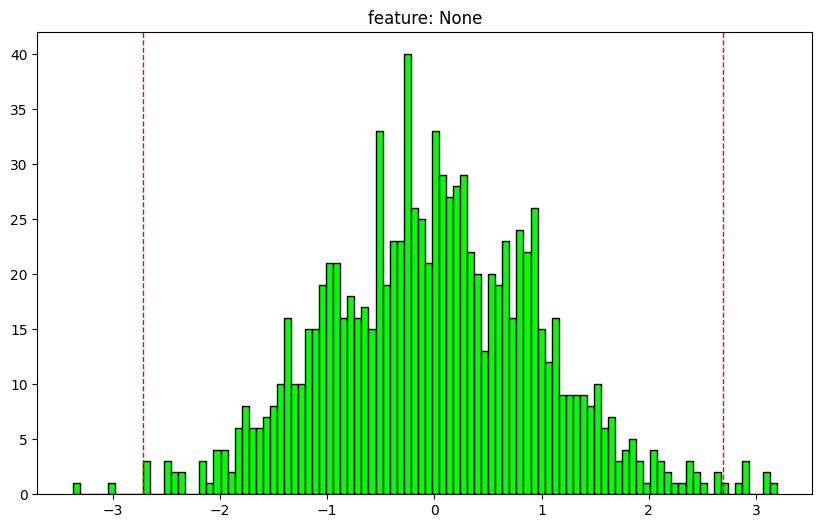

In [ ]:
x = np.random.normal(size=(1000))
analyze_array(x)

 array shape: (1000, 2)

  0  feature: 0

       dtype: float64
  nan values: 0.0%
         max: 19.34161521120589
           1: -9.521267646388687
          25: -0.0470111656023188
          50: 3.566494543750938
          75: 6.820831202240424
          99: 13.683667802761658
         min: -13.143794308827092
 outlier min: -10.348774717366434
 outlier max: 17.12259475400454
    outliers: 0.8%
        mean: 3.303848320692596
         std: 5.149018878780698
 normal dist: True


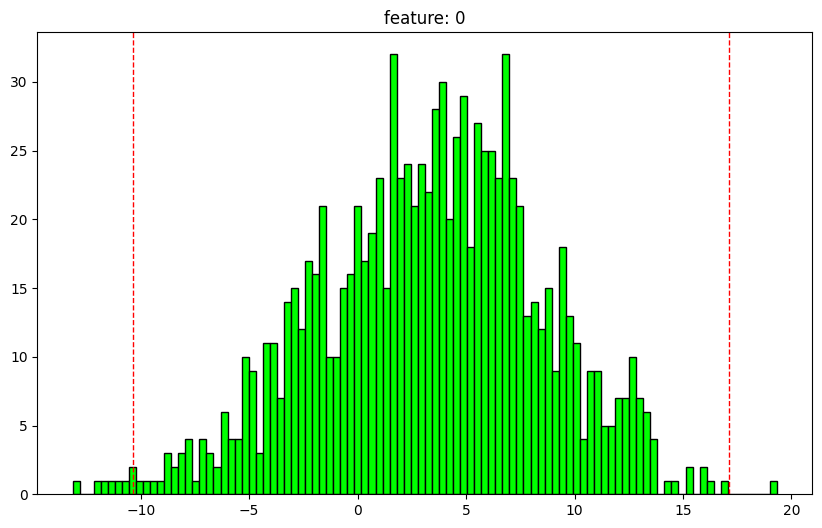


  1  feature: 1

       dtype: float64
  nan values: 0.0%
         max: 20.672094144356908
           1: -8.56533399982716
          25: -0.38884250023654826
          50: 2.732623188793667
          75: 6.128916801264278
          99: 13.75431022041546
         min: -10.561435870109753
 outlier min: -10.165481452487787
 outlier max: 15.905555753515518
    outliers: 0.5%
        mean: 2.8251747667882583
         std: 4.84283364242821
 normal dist: True


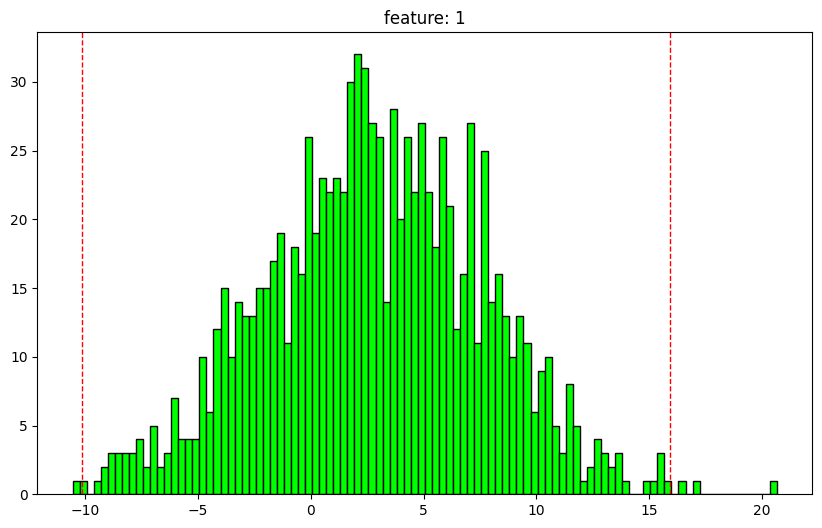

In [ ]:
x1 = np.random.normal(size=(1000,2))
x2 = np.random.normal(3, 5, size=(1000,2))
x = x1 + x2
analyze_array(x)

In [ ]:
#|export
def get_relpath(path):
    current_path = os.getcwd()
    if is_listy(path):
        relpaths = []
        for p in path:
            relpaths.append(os.path.relpath(p, current_path))
        return relpaths
    else:
        return os.path.relpath(path, current_path)

In [ ]:
#|export
def get_root():
    "Returns the root directory of the git repository."
    import subprocess
    git_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
    return git_root


def to_root_path(path):
    "Converts a path to an absolute path from the root directory of the repository."
    if path is None:
        return path
    path = Path(path)
    if path.is_absolute():
        return path
    else:
        return Path(get_root()) / path

In [ ]:
#|export
def split_in_chunks(o, chunksize, start=0, shuffle=False, drop_last=False):
    stop = ((len(o) - start)//chunksize*chunksize) if drop_last else None
    chunk_list = []
    for s in np.arange(len(o))[start:stop:chunksize]:
        chunk_list.append(np.random.permutation(o[slice(s, s+chunksize)]) if shuffle else o[slice(s, s+chunksize)])
    if shuffle: random.shuffle(chunk_list)
    return chunk_list

In [ ]:
a = np.arange(5, 15)
test_eq(split_in_chunks(a, 3, drop_last=False), [array([5, 6, 7]), array([ 8,  9, 10]), array([11, 12, 13]), array([14])])
test_eq(split_in_chunks(a, 3, drop_last=True), [array([5, 6, 7]), array([ 8,  9, 10]), array([11, 12, 13])])
test_eq(split_in_chunks(a, 3, start=2, drop_last=True), [array([7, 8, 9]), array([10, 11, 12])])

In [ ]:
#|export
def save_object(o, file_path, verbose=True):
    file_path = Path(file_path)
    if not file_path.suffix == '.pkl':
        file_path = file_path.parent / (file_path.name + '.pkl')
    create_dir(file_path.parent, verbose)
    joblib.dump(o, file_path, )
    pv(f'{type(o).__name__} saved as {file_path}', verbose)
    
def load_object(file_path):
    file_path = Path(file_path)
    if not file_path.suffix == '.pkl':
        file_path = file_path.parent / (file_path.name + '.pkl')
    return joblib.load(file_path)

In [ ]:
split = np.arange(100)
save_object(split, file_path='data/test')
split2 = load_object('data/test.pkl')
test_eq(split, split2)

data directory already exists.
ndarray saved as data/test.pkl


In [ ]:
splits = L([[[0,1,2,3,4], [5,6,7,8,9]],[[10,11,12,13,14], [15,16,17,18,19]]])
save_object(splits, file_path=Path('data/test'))
splits2 = load_object('data/test')
test_eq(splits, splits2)

data directory already exists.
L saved as data/test.pkl


In [ ]:
#|export
def get_idxs_to_keep(o, cond, crit='all', invert=False, axis=(1,2), keepdims=False):
    idxs_to_keep = cond(o)
    if isinstance(o, torch.Tensor):
        axis = tuplify(axis)
        for ax in axis[::-1]: 
            if crit == 'all':
                idxs_to_keep = torch.all(idxs_to_keep, axis=ax, keepdim=keepdims)
            elif crit == 'any':
                idxs_to_keep = torch.any(idxs_to_keep, axis=ax, keepdim=keepdims)
        if invert: idxs_to_keep =  ~idxs_to_keep
        return idxs_to_keep
    else: 
        if crit == 'all':
            idxs_to_keep = np.all(idxs_to_keep, axis=axis, keepdims=keepdims)
        elif crit == 'any':
            idxs_to_keep = np.any(idxs_to_keep, axis=axis, keepdims=keepdims)
        if invert: idxs_to_keep = ~idxs_to_keep
        return idxs_to_keep

In [ ]:
a = np.random.rand(100, 2, 10)
a[a > .95] = np.nan
idxs_to_keep = get_idxs_to_keep(a, np.isfinite)
if idxs_to_keep.size>0: 
    test_eq(np.isnan(a[idxs_to_keep]).sum(), 0)

In [ ]:
#|export
def zerofy(a, stride, keep=False):
    "Create copies of an array setting individual/ group values to zero "
    if keep:
        a_copy = a.copy()[None]
    a = a[None]
    add_steps = np.int32(np.ceil(a.shape[2] / stride) * stride - a.shape[2])
    if add_steps > 0:
        a = np.concatenate([np.zeros((a.shape[0], a.shape[1], add_steps)), a], -1)
    a = a.repeat(a.shape[1] * a.shape[2] / stride, 0)
    a0 = np.arange(a.shape[0])[:, None]
    a1 = np.repeat(np.arange(a.shape[1]), a.shape[0] // a.shape[1])[:, None]
    a2 = np.lib.stride_tricks.sliding_window_view(np.arange(a.shape[-1]), stride, 0)[::stride]
    a2 = np.repeat(a2[None], stride * a.shape[0] / a.shape[2], axis=0).reshape(-1, stride)
    a[a0, a1, a2] = 0
    if add_steps > 0:
        a = a[..., add_steps:]
    if keep:
        return np.concatenate([a_copy, a])
    else: 
        return a

In [ ]:
stride = 3
a = np.arange(2*5).reshape(2,5) + 1

zerofy(a, stride, keep=False)

array([[[ 0.,  0.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.]],

       [[ 1.,  2.,  0.,  0.,  0.],
        [ 6.,  7.,  8.,  9., 10.]],

       [[ 1.,  2.,  3.,  4.,  5.],
        [ 0.,  0.,  8.,  9., 10.]],

       [[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  0.,  0.,  0.]]])

In [ ]:
#|export
def feat2list(o):
    if o is None: return []
    elif isinstance(o, str): return [o]
    return list(o)

In [ ]:
a = 'a'
test_eq(feat2list(a), ['a'])
a = ['a', 'b']
test_eq(feat2list(a), ['a', 'b'])
a = None
test_eq(feat2list(a), [])

In [ ]:
#|export
def smallest_dtype(num, use_unsigned=False):
    "Find the smallest dtype that can safely hold `num`"
    if use_unsigned:
        int_dtypes = ['uint8', 'uint16', 'uint32', 'uint64']
        float_dtypes = ['float16', 'float32']
        float_bounds = [2**11, 2**24] # 2048, 16777216
    else:
        int_dtypes = ['int8', 'int16', 'int32', 'int64']
        float_dtypes = ['float16', 'float32', 'float64']
        float_bounds = [2**11, 2**24, 2**53] # 2048, 16777216, 9007199254740992
    if isinstance(num, Integral):
        for dtype in int_dtypes:
            if np.iinfo(dtype).min <= num <= np.iinfo(dtype).max: 
                return np.dtype(dtype)
        raise ValueError("No dtype found")
    elif isinstance(num, float):
        for dtype, bound in zip(float_dtypes, float_bounds):
            num = round(num)
            if -bound <= num <= bound: 
                return np.dtype(dtype)
        raise ValueError("No dtype found")
    else:
        raise ValueError("Input is not a number")

In [ ]:
test_eq(smallest_dtype(3654), 'int16')
test_eq(smallest_dtype(2048.), 'float16')
test_eq(smallest_dtype(365454), 'int32')
test_eq(smallest_dtype(365454.), 'float32')
test_eq(smallest_dtype(3654545134897), 'int64')

In [ ]:
#|export
def plot_forecast(X_true, y_true, y_pred, sel_vars=None, idx=None, figsize=(8, 4), n_samples=1):
    
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    def _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=None, figsize=(8, 4)):
        if idx is None:
            idx = np.random.randint(0, len(X_true))
        if sel_var is None:
            title = f'sample: {idx}'
        else:
            title = f'sample: {idx} sel_var: {sel_var}'
        if sel_var is None: sel_var = slice(None)
        pred = np.concatenate([X_true[idx, sel_var], y_pred[idx, sel_var]], -1)
        pred[..., :X_true.shape[-1]] = np.nan

        true = np.concatenate([X_true[idx, sel_var], y_true[idx, sel_var]], -1)
        true_hist = true.copy()
        true_fut = true.copy()
        true_hist[..., X_true.shape[-1]:] = np.nan
        true_fut[..., :X_true.shape[-1]] = np.nan

        plt.figure(figsize=figsize)
        plt.plot(pred.T, color='orange', lw=1, linestyle='--')
        plt.plot(true_hist.T, color='purple', lw=1)
        plt.plot(true_fut.T, color='purple', lw=1, linestyle='--')
        plt.axvline(X_true.shape[-1] - 1, color='gray', lw=.5, linestyle='--')
        
        plt.title(title)
        plt.xlim(0, X_true.shape[-1] + y_true.shape[-1])
        pred_patch = mpatches.Patch(color='orange', label='pred')
        true_patch = mpatches.Patch(color='purple', label='true')
        plt.legend(handles=[true_patch, pred_patch], loc='best')
        plt.show()
        
    assert X_true.shape[:-1] == y_true.shape[:-1] == y_pred.shape[:-1]
    assert y_true.shape[-1] == y_pred.shape[-1]
    
    if idx is not None:
        idx = listify(idx)
        n_samples = len(idx)
        iterator = idx
    else:
        iterator = random_randint(len(X_true), size=n_samples)
    
    if sel_vars is None:
        for idx in iterator:
            _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=idx, figsize=figsize)
    else:
        for idx in iterator:
            if sel_vars is True:
                sel_vars = np.arange(y_true.shape[1])
            else:
                sel_vars = listify(sel_vars)
            for sel_var in sel_vars:
                _plot_forecast(X_true, y_true, y_pred, sel_var=sel_var, idx=idx, figsize=figsize)

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/002_utils.ipynb saved at 2023-03-09 17:42:04
Correct notebook to script conversion! 😃
Thursday 09/03/23 17:42:08 CET
